#**Chicago Car Crash Analysis**
Flatiron School Phase 3 Data Science Project

July 14, 2023

##Team Members:
* [Morgan Goode](https://www.linkedin.com/in/morgangoode/), Tech Lead
* [Sean Harris](https://www.linkedin.com/in/sean-harris-data-sci-and-finance/), GitHub Lead
* [Jimmy McLaughlin](https://www.linkedin.com/in/james-mclaughlin-wm/), Tableau & Presentation Lead

##Project Links

*   [Tableau Dashboard](https://public.tableau.com/app/profile/james.mclaughlin2891/viz/AlcoholRelatedCrashesinChicago/Dashboard3?publish=yes)
*   [Presentation](https://github.com/smharris312/Chicago-Vehicle-Crash-Analysis/blob/main/Chicago_Crash_Data_Presentation.pdf)



___

#Business Understanding


##Stakeholders:
* Mayor Bandon Johnson
* Vision Zero

##Background:
Vision Zero is Chicago’s commitment to eliminating fatalities and serious injuries from traffic crashes. They believe that every crash is but a predictable and preventable occurrence and that no traffic-related death is acceptable.

##Our Goal:
In this hypothetical scenario, our team has been tasked with analyzing Chicago crash data provided by the city in order to predict loss of life or severe injury (alternately referred to as an incapacitating injury) in the event of a car crash involving an impaired driver.




___

#Data Overview

The Chicago Data Portal provides the public with datasets on traffic crashes from 2013 through the present. We used two tables to conduct our analysis:



1.   [Crashes](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if) contains data on each traffic crash on that takes place in the city and falls under the jurisdiction of the Chicago Police Department.
2.   [People](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d) contains data on people involved in a crash and if any injuries were sustained.



##Merging and Filtering


We merged `people` with `crashes` and filtered by date beginning with 2018 (the first year complete data is available) through 2023.

Our initial 2018 - 2023 dataset contained ~1.3 million records of people involved in ~700K car crashes.

Filtering for crashes involving **impaired** people resulted in ~13.3K people involved in ~7.7K crashes.


##Features of Interest

###Defining **impaired**:
 * people 21+ with a blood alcohol content (BAC) >= 0.08, people < 21 with a BAC < 0.0;
 * people whose physical condition was determined to have contributed to the accident and was described as having involved substances (e.g.: alcohol, drugs, medication, etc.).
 * crashes where the primary and/or secondary cause was due to drugs or alcohol



###Primary features of interest:
* from people data:
  * physical condition
  * blood alcohol content and test status (e.g.: taken, not offered, refused etc.)
  * person type (e.g.: driver, passenger, pedestrian, cyclist, etc.)
  * age
  * sex
* from crash data:
  * primary crash cause
  * secondary crash cause
  * crash type (injury/tow or no injury/drive away)
  * hit and run (Y/N)
  * total severe injuries and fatalities
  * crash hour
  * lighting condition
  * posted speed limit
  * location (latitude and longitude)
* new custom/aggregate features:
  * is driver (Y/N)
  * total drivers in crash
  * under influence (Y/N)
  * total serious injuries (inclusive of fatal and incapacitating)
  * has serious injury (Y/N) <-- our target column



##Data Limitations
Incomplete records containing null values as well as values that appeared to be obvious human clerical errors (such as -177-year-old or a 3-year-old drunk driver) necessitated cleaning and imputation.

___

# Exploratory Data Analysis (EDA), Data Cleaning, and Visualizations

####Loading packages and dependencies

In [ ]:
!pip install dabl

In [2]:
import pandas as pd
import numpy as np
import dabl
import sqlalchemy
from sqlalchemy import create_engine, text
import sqlite3
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score, precision_score, recall_score,  confusion_matrix,\
precision_recall_fscore_support, f1_score, roc_auc_score, roc_curve

from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier,  plot_tree
from sklearn.feature_selection import SelectFromModel

from sklearn import svm
import random
import warnings
warnings.filterwarnings("ignore")

####Importing the data and reading it in with both `pandas` and `SQL`

In [197]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Create the engine to connect to the inbuilt sqllite database
engine = create_engine("sqlite+pysqlite:///:memory:")

In [6]:
# create people dataframe
people_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Phase3-Project-Data/Traffic_Crashes_-_People.csv")

In [7]:
# rename `BAC_RESULT VALUE` to `BAC_RESULT_VALUE ` to make it compatible with SQL
people_df.rename(columns={"BAC_RESULT VALUE": "BAC_RESULT_VALUE"}, inplace=True)

In [8]:
# write records stored in people DataFrame to a SQL database
people_df.to_sql('people', con=engine, if_exists='replace')

1620956

In [9]:
# create crashes dataframe
crashes_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Phase3-Project-Data/Traffic_Crashes_-_Crashes.csv")

In [10]:
# write records stored in crashes DataFrame to a SQL database
crashes_df.to_sql('crashes', con=engine, if_exists='replace')

739105

##Exploring the data in both tables using pandas and SQL

###Exploring `crashes`


#### Previewing features that appear important based on industry research

In [11]:
# group by PRIM_CONTRIBUTORY CAUSE
# the results from sorting by crash date reveal we need to make that feature a datetime object
# for accurate sorting as this table begins in 2013

query = \
"""
SELECT CRASH_DATE, CRASH_HOUR, CRASH_DAY_OF_WEEK, CRASH_TYPE, PRIM_CONTRIBUTORY_CAUSE, SEC_CONTRIBUTORY_CAUSE,
INJURIES_TOTAL, INJURIES_FATAL,WEATHER_CONDITION, LIGHTING_CONDITION, ROADWAY_SURFACE_COND, ROAD_DEFECT,
COUNT(CRASH_RECORD_ID) AS num_crashes
FROM crashes
GROUP BY PRIM_CONTRIBUTORY_CAUSE
ORDER BY CRASH_DATE DESC;

"""
df_causes = pd.read_sql_query(sql=text(query), con=engine.connect())

In [12]:
df_causes.head(3)

,CRASH_DATE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_TYPE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,INJURIES_TOTAL,INJURIES_FATAL,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,ROAD_DEFECT,num_crashes
0,12/24/2017 04:15:00 PM,16,1,NO INJURY / DRIVE AWAY,TURNING RIGHT ON RED,NOT APPLICABLE,0.0,0.0,SNOW,DAWN,SNOW OR SLUSH,UNKNOWN,535
1,12/03/2019 02:22:00 PM,14,3,INJURY AND / OR TOW DUE TO CRASH,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,FAILING TO REDUCE SPEED TO AVOID CRASH,1.0,0.0,CLEAR,DAYLIGHT,DRY,NO DEFECTS,24290
2,11/26/2018 10:00:00 AM,10,2,NO INJURY / DRIVE AWAY,WEATHER,UNABLE TO DETERMINE,0.0,0.0,SNOW,DAYLIGHT,SNOW OR SLUSH,NO DEFECTS,11472


Since the query grouped by primary contributory cause we only expect to see one value. This list is long and could benefit from grouping into broader categories.

In [ ]:
df_causes['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

TURNING RIGHT ON RED                                                                1
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                 1
DRIVING ON WRONG SIDE/WRONG WAY                                                     1
BICYCLE ADVANCING LEGALLY ON RED LIGHT                                              1
DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)         1
PASSING STOPPED SCHOOL BUS                                                          1
IMPROPER OVERTAKING/PASSING                                                         1
HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)                                     1
UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)                  1
RELATED TO BUS STOP                                                                 1
IMPROPER TURNING/NO SIGNAL                                                          1
ROAD ENGINEERING/SURFACE/MARKING DEFECTS              

In [ ]:
# sorting by counting crash record ID, grouping by PRIM_CONTRIBUTORY CAUSE, and ordering by num_crashes
# gives us the top 10 crash causes in our full crashes dataset

query = \
"""
SELECT PRIM_CONTRIBUTORY_CAUSE, SEC_CONTRIBUTORY_CAUSE, CRASH_HOUR, CRASH_TYPE,
INJURIES_TOTAL, INJURIES_FATAL, COUNT(CRASH_RECORD_ID) AS num_crashes
FROM crashes
GROUP BY PRIM_CONTRIBUTORY_CAUSE
ORDER BY num_crashes DESC
LIMIT 10;
"""
df_causes_2 = pd.read_sql_query(sql=text(query), con=engine.connect())

Below we can see the top ten primary causes of all crashes as well as the crash count:

In [ ]:
df_causes_2

,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,CRASH_HOUR,CRASH_TYPE,INJURIES_TOTAL,INJURIES_FATAL,num_crashes
0,UNABLE TO DETERMINE,UNABLE TO DETERMINE,0,NO INJURY / DRIVE AWAY,0.0,0.0,285453
1,FAILING TO YIELD RIGHT-OF-WAY,UNABLE TO DETERMINE,16,INJURY AND / OR TOW DUE TO CRASH,1.0,0.0,80876
2,FOLLOWING TOO CLOSELY,UNABLE TO DETERMINE,14,INJURY AND / OR TOW DUE TO CRASH,1.0,0.0,73068
3,NOT APPLICABLE,NOT APPLICABLE,19,NO INJURY / DRIVE AWAY,0.0,0.0,39036
4,IMPROPER OVERTAKING/PASSING,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",17,NO INJURY / DRIVE AWAY,0.0,0.0,36078
5,FAILING TO REDUCE SPEED TO AVOID CRASH,FAILING TO REDUCE SPEED TO AVOID CRASH,17,NO INJURY / DRIVE AWAY,0.0,0.0,31296
6,IMPROPER BACKING,UNABLE TO DETERMINE,11,NO INJURY / DRIVE AWAY,0.0,0.0,29717
7,IMPROPER LANE USAGE,NOT APPLICABLE,17,NO INJURY / DRIVE AWAY,0.0,0.0,26953
8,IMPROPER TURNING/NO SIGNAL,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,14,INJURY AND / OR TOW DUE TO CRASH,1.0,0.0,24469
9,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,FAILING TO REDUCE SPEED TO AVOID CRASH,14,INJURY AND / OR TOW DUE TO CRASH,1.0,0.0,24290


See how the top ten primary cause list changes when we join on people and filter for our `Under_Influence` feature definition:

In [ ]:
crashes_people_under_influence_query = \
"""
SELECT C.PRIM_CONTRIBUTORY_CAUSE, C.SEC_CONTRIBUTORY_CAUSE, P.PHYSICAL_CONDITION,
C.CRASH_HOUR, C.CRASH_TYPE, C.INJURIES_TOTAL, C.INJURIES_FATAL, COUNT(C.CRASH_RECORD_ID) AS num_crashes
FROM crashes AS C
LEFT JOIN people AS P ON C.CRASH_RECORD_ID = P.CRASH_RECORD_ID
WHERE
(P.PHYSICAL_CONDITION IN ('IMPAIRED - ALCOHOL', 'HAD BEEN DRINKING', 'IMPAIRED - DRUGS',
                          'IMPAIRED - ALCOHOL AND DRUGS', 'MEDICATED') OR
 C.PRIM_CONTRIBUTORY_CAUSE IN ('HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)',
                               'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)')) AND
 ((P.BAC_RESULT_VALUE >= .08 AND P.AGE >=21) OR
 (P.BAC_RESULT_VALUE > 0.0 AND P.AGE < 21))
GROUP BY C.PRIM_CONTRIBUTORY_CAUSE
ORDER BY num_crashes DESC
LIMIT 10;
"""
df_causes_people = pd.read_sql_query(sql=text(crashes_people_under_influence_query), con=engine.connect())

In [ ]:
df_causes_people

,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,PHYSICAL_CONDITION,CRASH_HOUR,CRASH_TYPE,INJURIES_TOTAL,INJURIES_FATAL,num_crashes
0,UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN...,NOT APPLICABLE,IMPAIRED - ALCOHOL,1,NO INJURY / DRIVE AWAY,0.0,0.0,1090
1,FAILING TO REDUCE SPEED TO AVOID CRASH,UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN...,IMPAIRED - ALCOHOL,17,INJURY AND / OR TOW DUE TO CRASH,0.0,0.0,107
2,PHYSICAL CONDITION OF DRIVER,IMPROPER LANE USAGE,IMPAIRED - ALCOHOL,0,NO INJURY / DRIVE AWAY,0.0,0.0,65
3,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN...,IMPAIRED - ALCOHOL,23,NO INJURY / DRIVE AWAY,0.0,0.0,38
4,UNABLE TO DETERMINE,NOT APPLICABLE,IMPAIRED - ALCOHOL,2,INJURY AND / OR TOW DUE TO CRASH,0.0,0.0,36
5,FOLLOWING TOO CLOSELY,NOT APPLICABLE,IMPAIRED - ALCOHOL,17,INJURY AND / OR TOW DUE TO CRASH,1.0,0.0,30
6,FAILING TO YIELD RIGHT-OF-WAY,UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN...,IMPAIRED - ALCOHOL,20,NO INJURY / DRIVE AWAY,0.0,0.0,30
7,IMPROPER LANE USAGE,UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN...,IMPAIRED - ALCOHOL AND DRUGS,0,INJURY AND / OR TOW DUE TO CRASH,0.0,0.0,29
8,DISREGARDING TRAFFIC SIGNALS,UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN...,IMPAIRED - ALCOHOL,1,INJURY AND / OR TOW DUE TO CRASH,1.0,0.0,28
9,HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE),DISREGARDING TRAFFIC SIGNALS,IMPAIRED - ALCOHOL,19,INJURY AND / OR TOW DUE TO CRASH,3.0,0.0,25


Interesting— only two distinct `CRASH_TYPE` values:
* NO INJURY / DRIVE AWAY
* INJURY AND / OR TOW DUE TO CRASH

and zero null values.

In [ ]:
query = \
"""
SELECT COUNT(DISTINCT CRASH_TYPE) AS num_crash_types_distinct
FROM crashes;
"""
df = pd.read_sql_query(sql=text(query), con=engine.connect())
df

,num_crash_types_distinct
0,2


In [ ]:
query = \
"""
SELECT COUNT(DISTINCT CRASH_TYPE) AS num_crash_types_null
FROM crashes
WHERE CRASH_TYPE IS NULL;
"""
df = pd.read_sql_query(sql=text(query), con=engine.connect())
df

,num_crash_types_null
0,0


####Exploring `INJURIES_TOTAL` and `DAMAGE`

`DAMAGE` may not be relevant to the target. These limited values as three distinct range objects that only go up to `OVER $1,500` make it a less informative feature as serious accidents can cause extensive damage well over $1,500.



In [ ]:
query = \
"""
SELECT INJURIES_TOTAL, DAMAGE
FROM crashes
WHERE INJURIES_TOTAL >= 1
LIMIT 5;
"""
df = pd.read_sql_query(sql=text(query), con=engine.connect())
df

,INJURIES_TOTAL,DAMAGE
0,1.0,"OVER $1,500"
1,1.0,$500 OR LESS
2,1.0,"OVER $1,500"
3,1.0,$500 OR LESS
4,1.0,"OVER $1,500"


In [ ]:
crashes_df["DAMAGE"].value_counts()

OVER $1,500      452293
$501 - $1,500    200769
$500 OR LESS      86043
Name: DAMAGE, dtype: int64

###Exploring crashes involving fatalities and severe injuries

####Creating a fatal crashes dataframe and exploring the range of values to see what we might want to use for modeling.

`CRASH_TYPE`, `PRIM_CONTRIBUTORY_CAUSE`, `SEC_CONTRIBUTORY_CAUSE`, `CRASH_HOUR` continue to stand out. `WEATHER_CONDITION` appears less relevant to our analysis as weather is only listed as the primary cause for one record. `LIGHTING_CONDITION` may be more informative for our target than `WEATHER`. Additionally, `PHYSICAL CONDITION OF DRIVER` and various driver actions listed in cause values predominate by far.

In [ ]:
query = \
"""
SELECT CRASH_DATE, CRASH_HOUR, CRASH_DAY_OF_WEEK, CRASH_TYPE, PRIM_CONTRIBUTORY_CAUSE, SEC_CONTRIBUTORY_CAUSE,
INJURIES_TOTAL, INJURIES_FATAL, WEATHER_CONDITION, LIGHTING_CONDITION, ROADWAY_SURFACE_COND, ROAD_DEFECT
FROM crashes
WHERE INJURIES_FATAL > 0;
"""
fatal_crashes_df = pd.read_sql_query(sql=text(query), con=engine.connect())

In [ ]:
fatal_crashes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CRASH_DATE               807 non-null    object 
 1   CRASH_HOUR               807 non-null    int64  
 2   CRASH_DAY_OF_WEEK        807 non-null    int64  
 3   CRASH_TYPE               807 non-null    object 
 4   PRIM_CONTRIBUTORY_CAUSE  807 non-null    object 
 5   SEC_CONTRIBUTORY_CAUSE   807 non-null    object 
 6   INJURIES_TOTAL           807 non-null    float64
 7   INJURIES_FATAL           807 non-null    float64
 8   WEATHER_CONDITION        807 non-null    object 
 9   LIGHTING_CONDITION       807 non-null    object 
 10  ROADWAY_SURFACE_COND     807 non-null    object 
 11  ROAD_DEFECT              807 non-null    object 
dtypes: float64(2), int64(2), object(8)
memory usage: 75.8+ KB


In [ ]:
fatal_crashes_df['CRASH_TYPE'].value_counts()

INJURY AND / OR TOW DUE TO CRASH    807
Name: CRASH_TYPE, dtype: int64

In [ ]:
fatal_crashes_df['LIGHTING_CONDITION'].value_counts()

DARKNESS, LIGHTED ROAD    408
DAYLIGHT                  304
DARKNESS                   50
DUSK                       26
DAWN                       14
UNKNOWN                     5
Name: LIGHTING_CONDITION, dtype: int64

In [ ]:
fatal_crashes_df['ROADWAY_SURFACE_COND'].value_counts()

DRY              636
WET              111
UNKNOWN           25
SNOW OR SLUSH     23
ICE                7
OTHER              5
Name: ROADWAY_SURFACE_COND, dtype: int64

In [ ]:
fatal_crashes_df['ROAD_DEFECT'].value_counts()

NO DEFECTS           679
UNKNOWN              105
WORN SURFACE          10
OTHER                  7
SHOULDER DEFECT        3
RUT, HOLES             2
DEBRIS ON ROADWAY      1
Name: ROAD_DEFECT, dtype: int64

In [ ]:
fatal_crashes_df['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

UNABLE TO DETERMINE                                                                 270
PHYSICAL CONDITION OF DRIVER                                                         75
FAILING TO YIELD RIGHT-OF-WAY                                                        72
FAILING TO REDUCE SPEED TO AVOID CRASH                                               69
NOT APPLICABLE                                                                       66
DISREGARDING TRAFFIC SIGNALS                                                         61
OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER     38
EXCEEDING AUTHORIZED SPEED LIMIT                                                     21
DRIVING ON WRONG SIDE/WRONG WAY                                                      20
UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)                   18
IMPROPER OVERTAKING/PASSING                                                          14
IMPROPER LANE USAGE             

In [ ]:
fatal_crashes_df['INJURIES_TOTAL'].value_counts()

1.0     506
2.0     157
3.0      61
4.0      33
5.0      27
6.0      10
7.0       6
8.0       3
9.0       2
10.0      1
17.0      1
Name: INJURIES_TOTAL, dtype: int64

In [ ]:
query = \
"""
SELECT SUM(INJURIES_TOTAL) AS total_injuries_fatal_crashes
FROM crashes
WHERE INJURIES_FATAL > 0;
"""
df = pd.read_sql_query(sql=text(query), con=engine.connect())
df

,total_injuries_fatal_crashes
0,1441.0


#### Creating a `fatal_or_incapacited_crashes_df` by adding `INJURIES_INCAPACITATING` to see how the values change and how much our record total increases.

In [ ]:
query = \
"""
SELECT CRASH_DATE, CRASH_HOUR, CRASH_DAY_OF_WEEK, CRASH_TYPE, PRIM_CONTRIBUTORY_CAUSE, SEC_CONTRIBUTORY_CAUSE,
MOST_SEVERE_INJURY, INJURIES_TOTAL, INJURIES_FATAL, DAMAGE, WEATHER_CONDITION, LIGHTING_CONDITION, ROADWAY_SURFACE_COND, ROAD_DEFECT
FROM crashes
WHERE INJURIES_FATAL > 0 OR INJURIES_INCAPACITATING > 0;
"""
fatal_or_incapacitated_crashes_df = pd.read_sql_query(sql=text(query), con=engine.connect())

In [ ]:
fatal_or_incapacitated_crashes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13378 entries, 0 to 13377
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CRASH_DATE               13378 non-null  object 
 1   CRASH_HOUR               13378 non-null  int64  
 2   CRASH_DAY_OF_WEEK        13378 non-null  int64  
 3   CRASH_TYPE               13378 non-null  object 
 4   PRIM_CONTRIBUTORY_CAUSE  13378 non-null  object 
 5   SEC_CONTRIBUTORY_CAUSE   13378 non-null  object 
 6   MOST_SEVERE_INJURY       13378 non-null  object 
 7   INJURIES_TOTAL           13378 non-null  float64
 8   INJURIES_FATAL           13378 non-null  float64
 9   DAMAGE                   13378 non-null  object 
 10  WEATHER_CONDITION        13378 non-null  object 
 11  LIGHTING_CONDITION       13378 non-null  object 
 12  ROADWAY_SURFACE_COND     13378 non-null  object 
 13  ROAD_DEFECT              13378 non-null  object 
dtypes: float64(2), int64(2

Our crash count has increased from 1,441 to 20,306 crashes by adding incapacitating injuries to fatalities, thereby giving us a lot more data to work with.

In [ ]:
query = \
"""
SELECT SUM(INJURIES_TOTAL) AS total_injuries_fatal_plus_incapacitated_crashes
FROM crashes
WHERE INJURIES_FATAL > 0 OR INJURIES_INCAPACITATING > 0;
"""
df = pd.read_sql_query(sql=text(query), con=engine.connect())
df

,total_injuries_fatal_plus_incapacitated_crashes
0,20306.0


In [ ]:
fatal_or_incapacitated_crashes_df.head()

,CRASH_DATE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_TYPE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,DAMAGE,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,ROAD_DEFECT
0,09/16/2022 10:00:00 PM,22,6,INJURY AND / OR TOW DUE TO CRASH,UNABLE TO DETERMINE,UNABLE TO DETERMINE,INCAPACITATING INJURY,1.0,0.0,"OVER $1,500",CLEAR,"DARKNESS, LIGHTED ROAD",DRY,NO DEFECTS
1,10/11/2022 06:45:00 PM,18,3,INJURY AND / OR TOW DUE TO CRASH,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,INCAPACITATING INJURY,1.0,0.0,$500 OR LESS,RAIN,"DARKNESS, LIGHTED ROAD",WET,NO DEFECTS
2,06/23/2019 09:45:00 PM,21,1,INJURY AND / OR TOW DUE TO CRASH,UNABLE TO DETERMINE,NOT APPLICABLE,INCAPACITATING INJURY,1.0,0.0,"OVER $1,500",CLOUDY/OVERCAST,DARKNESS,WET,NO DEFECTS
3,10/06/2018 02:29:00 PM,14,7,INJURY AND / OR TOW DUE TO CRASH,IMPROPER OVERTAKING/PASSING,FOLLOWING TOO CLOSELY,INCAPACITATING INJURY,1.0,0.0,$500 OR LESS,CLOUDY/OVERCAST,DAYLIGHT,DRY,NO DEFECTS
4,07/15/2022 11:10:00 AM,11,6,INJURY AND / OR TOW DUE TO CRASH,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,INCAPACITATING INJURY,1.0,0.0,"OVER $1,500",RAIN,DAYLIGHT,WET,NO DEFECTS


####Visualizing `fatal_or_incapacitated_crashes.df` by `CRASH_HOUR`

Note: our dataset uses a 24-hour clock (military time).

The data documentation indicated 3-6 pm as peak crash hours, which makes sense as the coincides with rush hour. Here we see the peak crash hours for those involving fatalities and incapacitating injuries occur later at night.

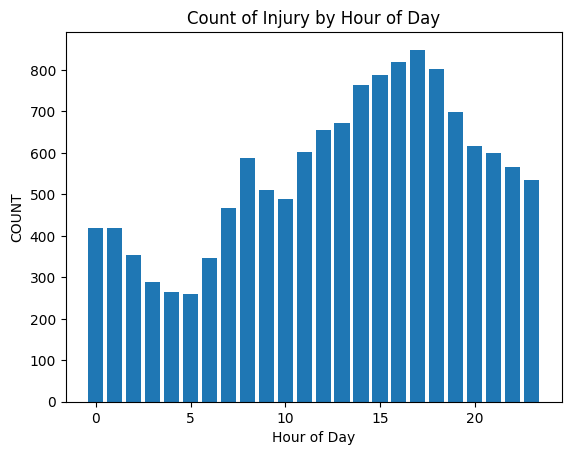

In [ ]:
hour_injury_counts = fatal_or_incapacitated_crashes_df['CRASH_HOUR'].value_counts()
hour_injury_counts = hour_injury_counts.sort_index()

plt.bar(hour_injury_counts.index, hour_injury_counts.values)
plt.xlabel('Hour of Day')
plt.ylabel('COUNT')
plt.title('Count of Injury by Hour of Day')
plt.show();

### Exploring `people`

In [ ]:
people_df.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,RD_NO,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,JD208731,827212.0,04/13/2020 10:50:00 PM,NaN,CHICAGO,IL,60620,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O10018,DRIVER,71162af7bf22799b776547132ebf134b5b438dcf3dac6b...,HY484534,9579.0,11/01/2015 05:00:00 AM,NaN,NaN,NaN,NaN,...,NaN,IMPROPER BACKING,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O10038,DRIVER,c21c476e2ccc41af550b5d858d22aaac4ffc88745a1700...,HY484750,9598.0,11/01/2015 08:00:00 AM,NaN,NaN,NaN,NaN,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O10039,DRIVER,eb390a4c8e114c69488f5fb8a097fe629f5a92fd528cf4...,HY484778,9600.0,11/01/2015 10:15:00 AM,NaN,NaN,NaN,NaN,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


In [ ]:
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620956 entries, 0 to 1620955
Data columns (total 30 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   PERSON_ID              1620956 non-null  object 
 1   PERSON_TYPE            1620956 non-null  object 
 2   CRASH_RECORD_ID        1620956 non-null  object 
 3   RD_NO                  1611422 non-null  object 
 4   VEHICLE_ID             1589096 non-null  float64
 5   CRASH_DATE             1620956 non-null  object 
 6   SEAT_NO                328084 non-null   float64
 7   CITY                   1182109 non-null  object 
 8   STATE                  1198599 non-null  object 
 9   ZIPCODE                1081986 non-null  object 
 10  SEX                    1595043 non-null  object 
 11  AGE                    1148419 non-null  float64
 12  DRIVERS_LICENSE_STATE  951724 non-null   object 
 13  DRIVERS_LICENSE_CLASS  801548 non-null   object 
 14  SAFETY_EQUIPMENT  

In [ ]:
people_df['PERSON_TYPE'].value_counts()

DRIVER                 1261495
PASSENGER               328084
PEDESTRIAN               18630
BICYCLE                  11143
NON-MOTOR VEHICLE         1320
NON-CONTACT VEHICLE        284
Name: PERSON_TYPE, dtype: int64

In [ ]:
people_df['INJURY_CLASSIFICATION'].value_counts()

NO INDICATION OF INJURY     1481963
NONINCAPACITATING INJURY      78139
REPORTED, NOT EVIDENT         44369
INCAPACITATING INJURY         14899
FATAL                           897
Name: INJURY_CLASSIFICATION, dtype: int64

####Exploring Blood Alcohol Content Data
Most records in our dataset do not have `BAC_RESULT_VALUE` data. These values from the `BAC_RESULT` column provide additional context: `'TEST REFUSED'`,`'TEST PERFORMED, RESULTS UNKNOWN'`. Late we will group these `BAC_RESULT` values  into three values:
1. `TEST NOT OFFERED`
2. `TEST REFUSED`
3. `TEST TAKEN`  

by combining `TEST PERFORMED, RESULTS UNKNOWN` with `TEST TAKEN` in order to clearly differentiate those who had a test from those who refused one and those who were not offered a test (presumably because their actions and comportment did not indicate any impairment).         

In [ ]:
people_df['BAC_RESULT'].value_counts()


TEST NOT OFFERED                   1271769
TEST REFUSED                         13668
TEST PERFORMED, RESULTS UNKNOWN       3162
TEST TAKEN                            2362
Name: BAC_RESULT, dtype: int64

In [ ]:
people_df['BAC_RESULT_VALUE'].value_counts()

0.00    182
0.18    129
0.17    128
0.21    115
0.14    109
0.20     99
0.16     92
0.19     88
0.15     81
0.22     79
0.23     74
0.12     70
0.13     70
0.11     67
0.24     62
0.26     47
0.25     45
0.27     35
0.10     35
0.09     32
0.28     31
0.08     22
0.29     18
0.07     18
0.03     17
0.30     16
0.33     16
0.04     15
0.05     11
0.32     10
0.35      9
0.02      8
0.31      8
0.06      8
0.38      7
0.36      4
0.34      4
0.39      3
0.44      3
0.01      3
1.00      2
0.79      2
0.88      2
0.45      2
0.60      2
0.95      1
0.40      1
0.47      1
0.99      1
0.41      1
0.80      1
0.58      1
0.37      1
0.85      1
0.67      1
0.98      1
Name: BAC_RESULT VALUE, dtype: int64

In [ ]:
query = \
"""
SELECT PERSON_TYPE, AGE, DRIVER_ACTION, PHYSICAL_CONDITION, BAC_RESULT, BAC_RESULT_VALUE
FROM people
WHERE BAC_RESULT_VALUE >=.08 AND AGE >=21
OR BAC_RESULT_VALUE > 0.0 AND AGE < 21
ORDER BY BAC_RESULT_VALUE DESC
LIMIT 10;
"""
df = pd.read_sql_query(sql=text(query), con=engine.connect())
df


,PERSON_TYPE,AGE,DRIVER_ACTION,PHYSICAL_CONDITION,BAC_RESULT,BAC_RESULT_VALUE
0,DRIVER,63.0,OTHER,IMPAIRED - ALCOHOL,TEST TAKEN,1.00
1,DRIVER,26.0,UNKNOWN,IMPAIRED - ALCOHOL,TEST TAKEN,1.00
2,DRIVER,62.0,OTHER,IMPAIRED - ALCOHOL,TEST TAKEN,0.99
3,DRIVER,59.0,UNKNOWN,IMPAIRED - ALCOHOL,TEST TAKEN,0.98
4,DRIVER,37.0,OTHER,IMPAIRED - ALCOHOL,TEST TAKEN,0.95
5,DRIVER,37.0,OTHER,IMPAIRED - ALCOHOL,TEST TAKEN,0.88
6,DRIVER,45.0,OTHER,IMPAIRED - ALCOHOL,TEST TAKEN,0.88
7,DRIVER,27.0,OTHER,IMPAIRED - ALCOHOL AND DRUGS,TEST TAKEN,0.85
8,DRIVER,35.0,FOLLOWED TOO CLOSELY,IMPAIRED - ALCOHOL,TEST TAKEN,0.80
9,DRIVER,28.0,FOLLOWED TOO CLOSELY,IMPAIRED - ALCOHOL,TEST TAKEN,0.79


In [ ]:
query = \
"""
SELECT *
FROM people
WHERE PERSON_TYPE = 'DRIVER';
"""
driver_df = pd.read_sql_query(sql=text(query), con=engine.connect())

In [ ]:
# We have mostly Drivers in our data set: 1,261,495
driver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261495 entries, 0 to 1261494
Data columns (total 31 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   index                  1261495 non-null  int64  
 1   PERSON_ID              1261495 non-null  object 
 2   PERSON_TYPE            1261495 non-null  object 
 3   CRASH_RECORD_ID        1261495 non-null  object 
 4   RD_NO                  1254163 non-null  object 
 5   VEHICLE_ID             1260853 non-null  float64
 6   CRASH_DATE             1261495 non-null  object 
 7   SEAT_NO                0 non-null        object 
 8   CITY                   956805 non-null   object 
 9   STATE                  942309 non-null   object 
 10  ZIPCODE                892791 non-null   object 
 11  SEX                    1261398 non-null  object 
 12  AGE                    921480 non-null   float64
 13  DRIVERS_LICENSE_STATE  951598 non-null   object 
 14  DRIVERS_LICENSE_CL

####Exploring intoxicated people involved in crashes

In [ ]:
# creating a dataframe with people who meet the legal intoxification requirement
# for ages >= 21 intoxication BAC is >= 0.08, for ages < 21, intoxication BAC > 0.0
query = \
"""
SELECT PERSON_ID, PERSON_TYPE, AGE, STATE, ZIPCODE, DRIVER_ACTION, DRIVER_VISION, PHYSICAL_CONDITION,
INJURY_CLASSIFICATION, BAC_RESULT, BAC_RESULT_VALUE, CRASH_DATE
FROM people
WHERE BAC_RESULT_VALUE >=.08 AND AGE >=21
OR BAC_RESULT_VALUE > 0.0 AND AGE < 21
ORDER BY BAC_RESULT_VALUE, CRASH_DATE DESC;
"""
dui_df = pd.read_sql_query(sql=text(query), con=engine.connect())


In [ ]:
dui_df.head()

,PERSON_ID,PERSON_TYPE,AGE,STATE,ZIPCODE,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,INJURY_CLASSIFICATION,BAC_RESULT,BAC_RESULT_VALUE,CRASH_DATE
0,O287294,DRIVER,20.0,IL,60609,IMPROPER LANE CHANGE,UNKNOWN,IMPAIRED - ALCOHOL,NO INDICATION OF INJURY,TEST TAKEN,0.02,12/22/2017 10:48:00 AM
1,O107074,DRIVER,20.0,IL,None,IMPROPER TURN,NOT OBSCURED,UNKNOWN,NO INDICATION OF INJURY,TEST TAKEN,0.02,12/13/2016 10:45:00 PM
2,O75772,DRIVER,19.0,IL,60623,DISREGARDED CONTROL DEVICES,UNKNOWN,NORMAL,NO INDICATION OF INJURY,TEST TAKEN,0.03,09/11/2016 11:30:00 PM
3,O820482,DRIVER,20.0,IL,60644,LICENSE RESTRICTIONS,UNKNOWN,HAD BEEN DRINKING,NO INDICATION OF INJURY,TEST TAKEN,0.03,01/04/2020 10:06:00 PM
4,O997449,DRIVER,19.0,IL,60517,TEXTING,NOT OBSCURED,IMPAIRED - ALCOHOL AND DRUGS,NO INDICATION OF INJURY,TEST TAKEN,0.04,11/21/2020 03:28:00 AM


Filtering `people` to include only legally intoxicated people shows most of them are drivers.

In [ ]:
dui_df['PERSON_TYPE'].value_counts()

DRIVER        1619
BICYCLE          1
PEDESTRIAN       1
Name: PERSON_TYPE, dtype: int64

####Exploring DUI driver age range

In [ ]:
# since two of these folks are not drivers, we will make a new query
dui_df['AGE'].value_counts()

27.0    78
23.0    74
25.0    73
24.0    71
26.0    68
        ..
76.0     1
81.0     1
1.0      1
3.0      1
75.0     1
Name: AGE, Length: 67, dtype: int64

Generating summary statistics for our legally intoxicated drivers reveals some issues with the `AGE` data. According to our uncleaned dataset the youngest DUI was 0.0 yeards old!

In [ ]:
query = \
"""
SELECT AVG(AGE) AS avg_dui_age, MAX(AGE) AS oldest_dui_age, MIN(AGE) AS youngest_dui_age
FROM people WHERE PERSON_TYPE = 'DRIVER'
AND BAC_RESULT_VALUE >=.08 AND AGE >=21
OR BAC_RESULT_VALUE > 0.0 AND AGE < 21
ORDER BY BAC_RESULT_VALUE DESC;
"""

ages_df = pd.read_sql_query(sql=text(query), con=engine.connect())

In [ ]:
ages_df

,avg_dui_age,oldest_dui_age,youngest_dui_age
0,35.192712,83.0,0.0


In [ ]:
# adding AGE IS NOT NULL query to see if that helps
query = \
"""
SELECT PERSON_ID, PERSON_TYPE, AGE, STATE, ZIPCODE, DRIVER_ACTION, DRIVER_VISION, PHYSICAL_CONDITION, INJURY_CLASSIFICATION,
BAC_RESULT, BAC_RESULT_VALUE, CRASH_DATE
FROM people
WHERE PERSON_TYPE = 'DRIVER' AND AGE IS NOT NULL
AND BAC_RESULT_VALUE >=.08 AND AGE >=21
OR BAC_RESULT_VALUE > 0.0 AND AGE < 21
ORDER BY BAC_RESULT_VALUE, CRASH_DATE DESC;
"""
dui_df3 = pd.read_sql_query(sql=text(query), con=engine.connect())

In [ ]:
# A 1-year-old driver? What is happening here?
dui_df3['AGE'].value_counts()

27.0    78
23.0    74
25.0    73
24.0    71
26.0    68
        ..
76.0     1
81.0     1
1.0      1
3.0      1
75.0     1
Name: AGE, Length: 67, dtype: int64

####What we learned re: `AGE` and drivers
**DUI Drivers:**

After further investigation into our DUI driver ages, we have 25 under the age of 5. These seem to be the result of clerical errors and will be replaced with `NaN` values. There are also 18 records of DUI drivers between the ages of 14 and 18, and 54 records of DUI drivers between the ages of 19 and 20.

After making several different DUI driver dataframes, we simplified with two: underage and legal adult.

**All Drivers:**

Chicagoans are eligible for learner's permits at age 14. However, we found some that were under the age of 14. Previewing the data suggests the 12-and 13-year-olds were in fact driving. So we will clean our data to replace drivers under the age of 12 with `NaN` values before imputing them.

####Creating an underage drinking dataframe

At first glance, it looks like driving impaired underage might not be as big of problem as we thought as it returned only 97 records. However, this query only pulls `AGE IS NOT NULL` records and we have yet to join data from crashes which gives additional features that can fill in the gaps when `BAC_RESULT_VALUE` is unavailable. We will use said crash features to create our new `Under_Infuence` boolean feature after we merge `people` with `crashes`.

In [ ]:
# AGE < 21
query = \
"""
SELECT PERSON_ID, PERSON_TYPE, AGE, STATE, ZIPCODE, DRIVER_ACTION, DRIVER_VISION,
PHYSICAL_CONDITION, INJURY_CLASSIFICATION, BAC_RESULT, BAC_RESULT_VALUE, CRASH_DATE
FROM people
WHERE PERSON_TYPE = 'DRIVER' AND AGE IS NOT NULL
AND BAC_RESULT_VALUE > 0.0 AND AGE < 21
ORDER BY AGE DESC;
"""
dui_under_age_df = pd.read_sql_query(sql=text(query), con=engine.connect())

In [ ]:
dui_under_age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PERSON_ID              97 non-null     object 
 1   PERSON_TYPE            97 non-null     object 
 2   AGE                    97 non-null     float64
 3   STATE                  95 non-null     object 
 4   ZIPCODE                92 non-null     object 
 5   DRIVER_ACTION          97 non-null     object 
 6   DRIVER_VISION          97 non-null     object 
 7   PHYSICAL_CONDITION     97 non-null     object 
 8   INJURY_CLASSIFICATION  97 non-null     object 
 9   BAC_RESULT             97 non-null     object 
 10  BAC_RESULT_VALUE       97 non-null     float64
 11  CRASH_DATE             97 non-null     object 
dtypes: float64(2), object(10)
memory usage: 9.2+ KB


**Generating Summary statistics on DUI's (excluding drivers < 16)**

In [ ]:
query = \
"""
SELECT AVG(AGE) AS avg_dui_age, MAX(AGE) AS oldest_dui_age, MIN(AGE) AS youngest_dui_age
FROM people
WHERE PERSON_TYPE = 'DRIVER'
AND BAC_RESULT_VALUE >=.08 AND AGE >=21.0
OR BAC_RESULT_VALUE > 0.0 AND AGE BETWEEN 16.0 AND 21.0
ORDER BY BAC_RESULT_VALUE DESC;
"""

dui_ages_df = pd.read_sql_query(sql=text(query), con=engine.connect())
dui_ages_df

,avg_dui_age,oldest_dui_age,youngest_dui_age
0,35.742158,83.0,16.0


Exploring legal adult DUI's

In [ ]:
query = \
"""
SELECT PERSON_ID, PERSON_TYPE, AGE, STATE, ZIPCODE, DRIVER_ACTION, DRIVER_VISION,
PHYSICAL_CONDITION, INJURY_CLASSIFICATION, BAC_RESULT, BAC_RESULT_VALUE, CRASH_DATE
FROM people
WHERE PERSON_TYPE = 'DRIVER'
AND BAC_RESULT_VALUE >=.08 AND AGE >=21.0
ORDER BY BAC_RESULT_VALUE DESC;
"""

dui_adult_df = pd.read_sql_query(sql=text(query), con=engine.connect())

In [ ]:
dui_adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522 entries, 0 to 1521
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PERSON_ID              1522 non-null   object 
 1   PERSON_TYPE            1522 non-null   object 
 2   AGE                    1522 non-null   float64
 3   STATE                  1496 non-null   object 
 4   ZIPCODE                1440 non-null   object 
 5   DRIVER_ACTION          1522 non-null   object 
 6   DRIVER_VISION          1522 non-null   object 
 7   PHYSICAL_CONDITION     1522 non-null   object 
 8   INJURY_CLASSIFICATION  1522 non-null   object 
 9   BAC_RESULT             1522 non-null   object 
 10  BAC_RESULT_VALUE       1522 non-null   float64
 11  CRASH_DATE             1522 non-null   object 
dtypes: float64(2), object(10)
memory usage: 142.8+ KB


**Generating Summary statistics on DUI's (excluding drivers < 21)**

The average age only drops slightly, and the youngest age will obviously be 21.
The value counts indicate clusters in adult DUI's during the late twenties and early thirties. (This aligns with the state-level age distribution described in [State of Illinois' DUI FACT BOOK ](https://www.ilsos.gov/publications/pdf_publications/dsd_a118.pdf) published earlier this year.)  This suggests the need to target prevention among those age groups.

In [ ]:
query = \
"""
SELECT AVG(AGE) AS avg_adult_dui_age, MAX(AGE) AS oldest_adult_dui_age, MIN(AGE) AS youngest_adult_dui_age
FROM people
WHERE PERSON_TYPE = 'DRIVER'
AND BAC_RESULT_VALUE >=.08 AND AGE >=21.0
ORDER BY BAC_RESULT_VALUE DESC;
"""

dui_adult_ages_df = pd.read_sql_query(sql=text(query), con=engine.connect())
dui_adult_ages_df

,avg_adult_dui_age,oldest_adult_dui_age,youngest_adult_dui_age
0,36.527595,83.0,21.0


In [ ]:
dui_adult_df['AGE'].value_counts()

27.0    78
23.0    74
25.0    73
24.0    71
26.0    68
28.0    61
31.0    57
32.0    53
37.0    51
29.0    50
30.0    49
22.0    48
34.0    47
38.0    45
21.0    44
35.0    38
36.0    37
33.0    37
40.0    36
39.0    36
41.0    36
42.0    34
49.0    29
45.0    24
50.0    23
46.0    21
43.0    20
55.0    18
56.0    18
52.0    18
59.0    18
44.0    17
47.0    16
58.0    16
54.0    16
57.0    15
53.0    13
51.0    13
48.0    12
60.0    12
63.0    11
61.0     9
65.0     8
62.0     8
64.0     8
66.0     6
67.0     6
69.0     6
68.0     4
71.0     2
80.0     2
74.0     2
77.0     2
75.0     1
81.0     1
70.0     1
83.0     1
82.0     1
76.0     1
Name: AGE, dtype: int64

####Visualizing DUI's by `AGE `and `DRIVER_ACTION`
These two features have the potential to be contributing variables for our target, so we created visualizations to explore this. We can see commonalities between the values contained in`DRIVER_ACTION` in `people` and those contained in `PRIM_CONTRIBUTORY_CAUSE` and `SEC_CONTRIBUTORY_CAUSE` in `crashes`. We should consider grouping `DRIVER_ACTION` as well.

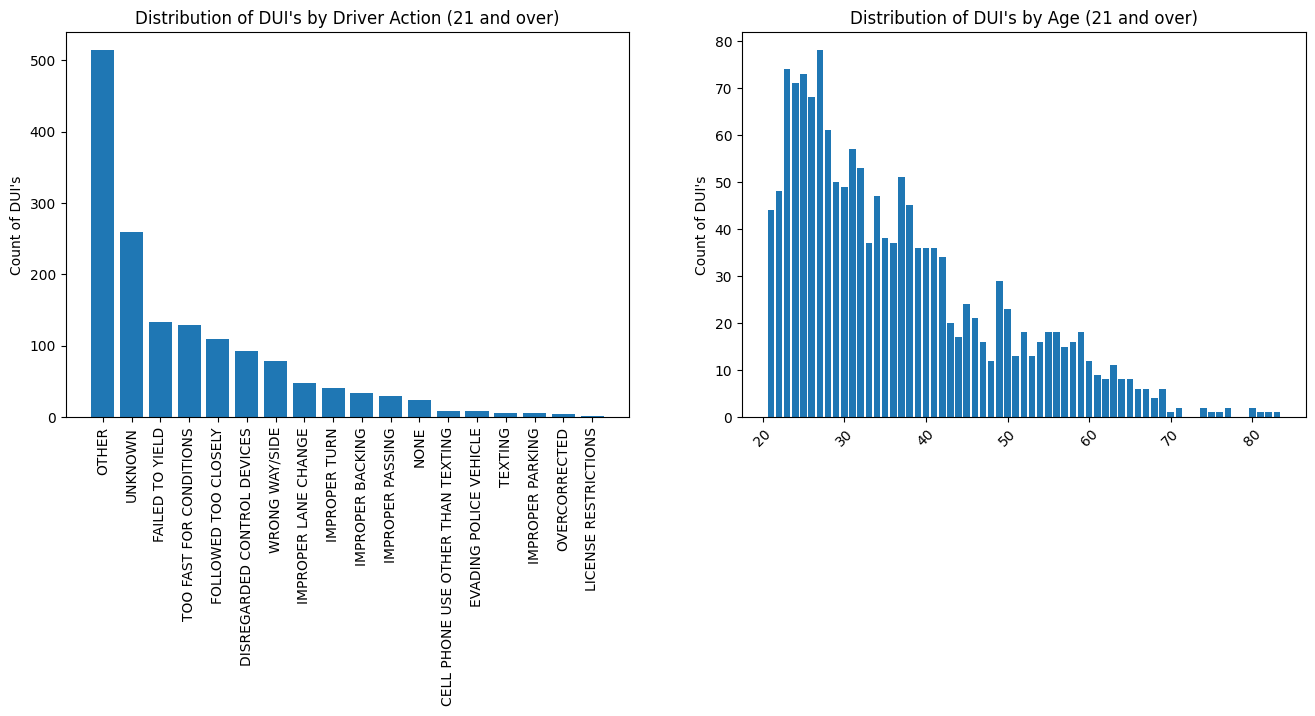

In [ ]:
# set up plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

# create variables for easier reuse
DRIVER_ACTION_counts = dui_adult_df['DRIVER_ACTION'].value_counts()
AGE_counts = dui_adult_df['AGE'].value_counts()

# plot data
ax1.bar(DRIVER_ACTION_counts.index, DRIVER_ACTION_counts.values)
ax2.bar(AGE_counts.index, AGE_counts.values)

# customize appearance
ax1.tick_params(axis="x", labelrotation=90)
ax2.tick_params(axis="x", labelrotation=45)
ax1.set_ylabel("Count of DUI's")
ax2.set_ylabel("Count of DUI's")
ax1.set_title("Distribution of DUI's by Driver Action (21 and over)")
ax2.set_title("Distribution of DUI's by Age (21 and over)");

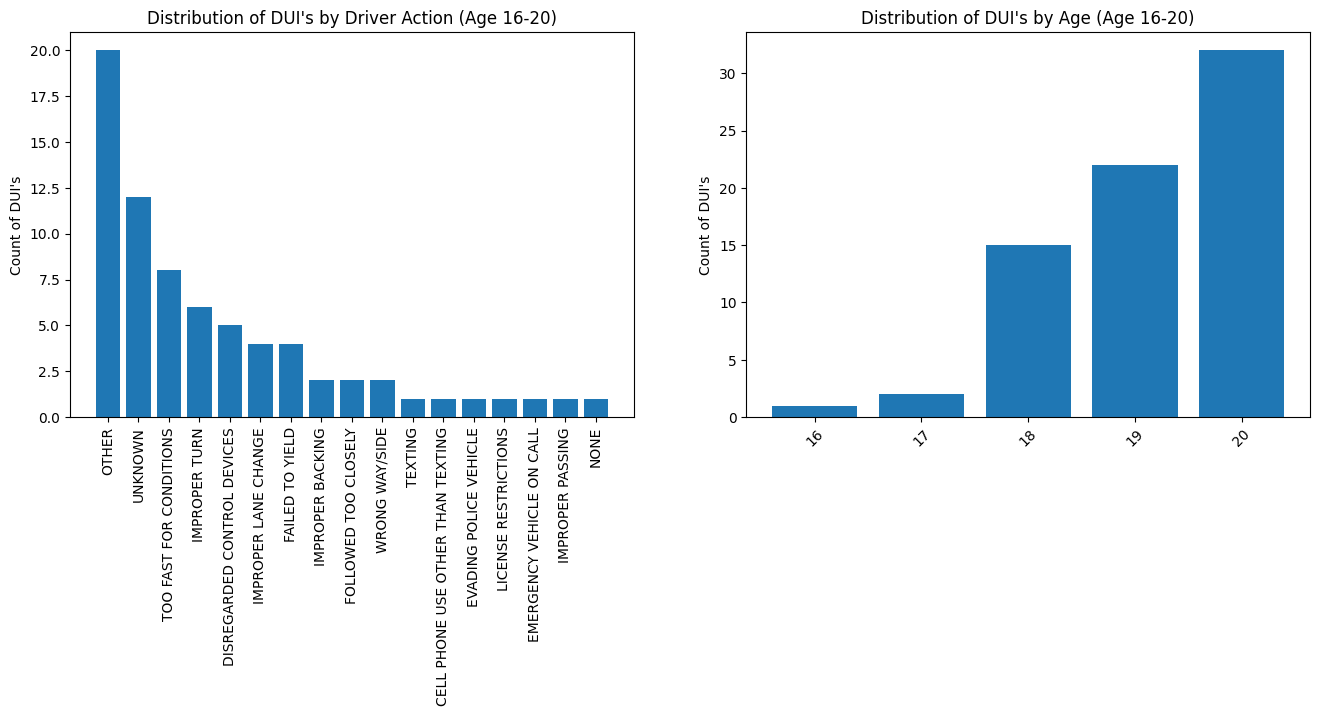

In [ ]:
# dui_under_age_df

# set up plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

# create variables for easier reuse
DRIVER_ACTION_counts = dui_under_age_df['DRIVER_ACTION'].value_counts()
AGE_counts = dui_under_age_df['AGE'].value_counts()

# plot data
ax1.bar(DRIVER_ACTION_counts.index, DRIVER_ACTION_counts.values)
ax2.bar(AGE_counts.index, AGE_counts.values)

# customize appearance
ax1.tick_params(axis="x", labelrotation=90)
ax2.tick_params(axis="x", labelrotation=45)
ax1.set_ylabel("Count of DUI's")
ax2.set_ylabel("Count of DUI's")
ax1.set_title("Distribution of DUI's by Driver Action (Age 16-20)")
ax2.set_title("Distribution of DUI's by Age (Age 16-20)");

##Creating our master dataset
Now that we have decided which columns we want from `people` and `crashes`, we will merge them into our master dataset.

STEPS:
1. Select columns want, create new datatypes
2. Filter by date: 2018 - 2023
3. Merge into one data set
4. Clean age and sex data
5. Create additional new feature columns


##`crashes` dataframe edit

In [15]:
selected_columns = ['CRASH_RECORD_ID', 'CRASH_DATE', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'POSTED_SPEED_LIMIT','WEATHER_CONDITION',
                    'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE', 'HIT_AND_RUN_I', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'MOST_SEVERE_INJURY',
                    'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'LATITUDE', 'LONGITUDE','LOCATION']
crashes_edit_df = crashes_df[selected_columns].copy()

In [16]:
#create simplified 'PRIM_CONTRIBUTORY_CAUSE' and 'SEC_CONTRIBUTORY_CAUSE' categories                                                      1982

def simplify_contributory_causes(df):
    replacements = {
        'PRIM_CONTRIBUTORY_CAUSE': {
            "CELL PHONE USE OTHER THAN TEXTING": 'DISTRACTED DRIVER',
            "DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)": 'DISTRACTED DRIVER',
            "DISTRACTION - FROM OUTSIDE VEHICLE": 'DISTRACTED DRIVER',
            "TEXTING": 'DISTRACTED DRIVER',
            "DISTRACTION - FROM INSIDE VEHICLE": 'DISTRACTED DRIVER',
            "UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)": 'UNDER THE INFLUENCE',
            "HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)": 'UNDER THE INFLUENCE',
            "DRIVING ON WRONG SIDE/WRONG WAY": 'DISREGARDED ROAD RULES',
            "IMPROPER OVERTAKING/PASSING": 'DISREGARDED ROAD RULES',
            "DISREGARDING ROAD MARKINGS": 'DISREGARDED ROAD RULES',
            "IMPROPER BACKING": 'DISREGARDED ROAD RULES',
            "DISREGARDING STOP SIGN": 'DISREGARDED ROAD RULES',
            "DISREGARDING TRAFFIC SIGNALS": 'DISREGARDED ROAD RULES',
            "DISREGARDING YIELD SIGN": 'DISREGARDED ROAD RULES',
            "IMPROPER LANE USAGE": 'DISREGARDED ROAD RULES',
            "IMPROPER TURNING/NO SIGNAL": 'DISREGARDED ROAD RULES',
            "FAILING TO YIELD RIGHT-OF-WAY": 'DISREGARDED ROAD RULES',
            "PASSING STOPPED SCHOOL BUS": 'DISREGARDED ROAD RULES',
            "TURNING RIGHT ON RED": 'DISREGARDED ROAD RULES',
            "FOLLOWING TOO CLOSELY": 'DISREGARDED ROAD RULES',
            "DISREGARDING OTHER TRAFFIC SIGNS": 'DISREGARDED ROAD RULES',
            "EXCEEDING AUTHORIZED SPEED LIMIT": 'SPEEDING/DRIVING TOO FAST',
            "FAILING TO REDUCE SPEED TO AVOID CRASH": 'SPEEDING/DRIVING TOO FAST',
            "EXCEEDING SAFE SPEED FOR CONDITIONS": 'SPEEDING/DRIVING TOO FAST',
            "ROAD ENGINEERING/SURFACE/MARKING DEFECTS": 'OUTSIDE CONDITIONS [NOT WEATHER]',
            "OBSTRUCTED CROSSWALKS": 'OUTSIDE CONDITIONS [NOT WEATHER]',
            "VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)": 'OUTSIDE CONDITIONS [NOT WEATHER]',
            "ROAD CONSTRUCTION/MAINTENANCE": 'OUTSIDE CONDITIONS [NOT WEATHER]',
            "ANIMAL": 'ANIMAL/EVASIVE ACTION',
            "EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST": 'ANIMAL/EVASIVE ACTION'
        },
        'SEC_CONTRIBUTORY_CAUSE': {
            "CELL PHONE USE OTHER THAN TEXTING": 'DISTRACTED DRIVER',
            "DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)": 'DISTRACTED DRIVER',
            "DISTRACTION - FROM OUTSIDE VEHICLE": 'DISTRACTED DRIVER',
            "TEXTING": 'DISTRACTED DRIVER',
            "DISTRACTION - FROM INSIDE VEHICLE": 'DISTRACTED DRIVER',
            "UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)": 'UNDER THE INFLUENCE',
            "HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)": 'UNDER THE INFLUENCE',
            "DRIVING ON WRONG SIDE/WRONG WAY": 'DISREGARDED ROAD RULES',
            "IMPROPER OVERTAKING/PASSING": 'DISREGARDED ROAD RULES',
            "DISREGARDING ROAD MARKINGS": 'DISREGARDED ROAD RULES',
            "IMPROPER BACKING": 'DISREGARDED ROAD RULES',
            "DISREGARDING STOP SIGN": 'DISREGARDED ROAD RULES',
            "DISREGARDING TRAFFIC SIGNALS": 'DISREGARDED ROAD RULES',
            "DISREGARDING YIELD SIGN": 'DISREGARDED ROAD RULES',
            "IMPROPER LANE USAGE": 'DISREGARDED ROAD RULES',
            "IMPROPER TURNING/NO SIGNAL": 'DISREGARDED ROAD RULES',
            "FAILING TO YIELD RIGHT-OF-WAY": 'DISREGARDED ROAD RULES',
            "PASSING STOPPED SCHOOL BUS": 'DISREGARDED ROAD RULES',
            "TURNING RIGHT ON RED": 'DISREGARDED ROAD RULES',
            "FOLLOWING TOO CLOSELY": 'DISREGARDED ROAD RULES',
            "DISREGARDING OTHER TRAFFIC SIGNS": 'DISREGARDED ROAD RULES',
            "EXCEEDING AUTHORIZED SPEED LIMIT": 'SPEEDING/DRIVING TOO FAST',
            "FAILING TO REDUCE SPEED TO AVOID CRASH": 'SPEEDING/DRIVING TOO FAST',
            "EXCEEDING SAFE SPEED FOR CONDITIONS": 'SPEEDING/DRIVING TOO FAST',
            "ROAD ENGINEERING/SURFACE/MARKING DEFECTS": 'OUTSIDE CONDITIONS [NOT WEATHER]',
            "OBSTRUCTED CROSSWALKS": 'OUTSIDE CONDITIONS [NOT WEATHER]',
            "VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)": 'OUTSIDE CONDITIONS [NOT WEATHER]',
            "ROAD CONSTRUCTION/MAINTENANCE": 'OUTSIDE CONDITIONS [NOT WEATHER]',
            "ANIMAL": 'ANIMAL/EVASIVE ACTION',
            "EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST": 'ANIMAL/EVASIVE ACTION'
    }}

    df.replace(replacements, inplace=True)

simplify_contributory_causes(crashes_edit_df)


In [17]:
crashes_edit_df['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

DISREGARDED ROAD RULES                                                              300858
UNABLE TO DETERMINE                                                                 285453
NOT APPLICABLE                                                                       39036
SPEEDING/DRIVING TOO FAST                                                            34962
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  24290
WEATHER                                                                              11472
DISTRACTED DRIVER                                                                     9865
OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER      9432
OUTSIDE CONDITIONS [NOT WEATHER]                                                      7819
EQUIPMENT - VEHICLE CONDITION                                                         4660
PHYSICAL CONDITION OF DRIVER                                                          4475

In [18]:
# make CRASH_DATE a datetime object so we can filter by date
crashes_edit_df['CRASH_DATE'] = pd.to_datetime(crashes_edit_df['CRASH_DATE'], errors='coerce' )

In [19]:
# preview our new dataframe
crashes_edit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739105 entries, 0 to 739104
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_RECORD_ID          739105 non-null  object        
 1   CRASH_DATE               739105 non-null  datetime64[ns]
 2   CRASH_HOUR               739105 non-null  int64         
 3   CRASH_DAY_OF_WEEK        739105 non-null  int64         
 4   CRASH_MONTH              739105 non-null  int64         
 5   POSTED_SPEED_LIMIT       739105 non-null  int64         
 6   WEATHER_CONDITION        739105 non-null  object        
 7   LIGHTING_CONDITION       739105 non-null  object        
 8   ROADWAY_SURFACE_COND     739105 non-null  object        
 9   ROAD_DEFECT              739105 non-null  object        
 10  CRASH_TYPE               739105 non-null  object        
 11  HIT_AND_RUN_I            230382 non-null  object        
 12  PRIM_CONTRIBUTOR

In [20]:
# filter by date to create a 2018 - 2023 dataframe
crashes_edit_df_2018_2023 = crashes_edit_df[(crashes_edit_df['CRASH_DATE'] > "2017-12-31 23:59:59")]

In [21]:
# sort by date to confirm
crashes_edit_df_2018_2023.sort_values(by='CRASH_DATE')

,CRASH_RECORD_ID,CRASH_DATE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,ROAD_DEFECT,...,HIT_AND_RUN_I,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,LATITUDE,LONGITUDE,LOCATION
111894,0ad333cd371ec3976f9fac8160ccfc91f0399b48a92b7f...,2018-01-01 00:00:00,0,2,1,25,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,...,Y,UNABLE TO DETERMINE,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,41.681735,-87.641014,POINT (-87.641013916869 41.681735373094)
631253,f798e1cdba8adfb80ee2aaeea541a55dd32fa8aff38494...,2018-01-01 00:00:00,0,2,1,20,CLEAR,DAYLIGHT,DRY,NO DEFECTS,...,Y,UNABLE TO DETERMINE,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,41.800575,-87.589225,POINT (-87.589225075066 41.80057461981)
209356,351626f25a540a0fccbe42fb815b14ae6c75c15676bf7c...,2018-01-01 00:00:00,0,2,1,30,CLEAR,UNKNOWN,UNKNOWN,UNKNOWN,...,Y,UNABLE TO DETERMINE,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,41.955842,-87.650268,POINT (-87.65026813462 41.955842185147)
573304,dfb3229940c672426c4010d7348d16b69b030191213b86...,2018-01-01 00:05:00,0,2,1,30,CLEAR,"DARKNESS, LIGHTED ROAD",UNKNOWN,UNKNOWN,...,NaN,UNABLE TO DETERMINE,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,41.949417,-87.668774,POINT (-87.66877431033 41.949417412921)
40841,821ee3270b2c503fd0905415f674d3f4a63e1ac15d9100...,2018-01-01 00:07:00,0,2,1,35,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,...,NaN,WEATHER,SPEEDING/DRIVING TOO FAST,NO INDICATION OF INJURY,0.0,0.0,0.0,41.683946,-87.622993,POINT (-87.622993129041 41.683945885086)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700084,19c606950b068ff6e704f68bcd42ac5379e3142850951e...,2023-07-06 22:20:00,22,5,7,30,CLEAR,DUSK,DRY,NO DEFECTS,...,NaN,DISREGARDED ROAD RULES,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,NO INDICATION OF INJURY,0.0,0.0,0.0,41.880345,-87.765601,POINT (-87.765601346906 41.880344977442)
705198,a1f562015cbc6bfecec083ee97dad0cca3d9f770682764...,2023-07-06 22:45:00,22,5,7,30,CLEAR,"DARKNESS, LIGHTED ROAD",DRY,NO DEFECTS,...,NaN,DISREGARDED ROAD RULES,NOT APPLICABLE,NO INDICATION OF INJURY,0.0,0.0,0.0,41.875533,-87.633804,POINT (-87.633803891217 41.875532652069)
708813,16ec144e4a39707b2d7c51fd924bc53dff5894de75d085...,2023-07-07 00:17:00,0,6,7,25,CLEAR,DARKNESS,DRY,NO DEFECTS,...,NaN,UNABLE TO DETERMINE,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,41.843576,-87.705160,POINT (-87.705160226138 41.843575982562)
708775,6663caed20a5a0bcdb424989ce70bd1e4bca71beffd4ba...,2023-07-07 00:19:00,0,6,7,30,CLEAR,DAWN,DRY,NO DEFECTS,...,NaN,DISREGARDED ROAD RULES,NOT APPLICABLE,NO INDICATION OF INJURY,0.0,0.0,0.0,41.892623,-87.763330,POINT (-87.763330444094 41.892623022942)


##`people` dataframe edit

In [158]:
selected_columns = ['PERSON_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'PERSON_TYPE', 'SEX', 'AGE', 'HOSPITAL', 'INJURY_CLASSIFICATION',
                    'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'BAC_RESULT', 'BAC_RESULT_VALUE']
people_edit_df = people_df[selected_columns].copy()

In [159]:
# Create 'is_driver' column in the 'people' dataframe so we can easily sort by whether someone is a driver or not
people_edit_df['is_driver'] = (people_edit_df['PERSON_TYPE'] == 'DRIVER').astype(int)

# Create 'total_drivers_in_crash' column by grouping by 'CRASH_RECORD_ID' and summing 'is_driver'
people_edit_df['total_drivers_in_crash'] = people_edit_df.groupby('CRASH_RECORD_ID')['is_driver'].transform('sum')

In [160]:
#create simplified DRIVER_ACTION categories

def simplify_driver_action(df):
    replacements = {
        'DRIVER_ACTION': {
            'UNKNOWN': 'OTHER',
            'FAILED TO YIELD': 'DISREGARDED ROAD RULES',
            'FOLLOWED TOO CLOSELY': 'DISREGARDED ROAD RULES',
            'IMPROPER BACKING': 'DISREGARDED ROAD RULES',
            'IMPROPER TURN': 'DISREGARDED ROAD RULES',
            'IMPROPER LANE CHANGE': 'DISREGARDED ROAD RULES',
            'IMPROPER PASSING': 'DISREGARDED ROAD RULES',
            'DISREGARDED CONTROL DEVICES': 'DISREGARDED ROAD RULES',
            'WRONG WAY/SIDE': 'DISREGARDED ROAD RULES',
            'IMPROPER PARKING': 'DISREGARDED ROAD RULES',
            'CELL PHONE USE OTHER THAN TEXTING': 'DISTRACTED DRIVER',
            'TEXTING': 'DISTRACTED DRIVER',
            'TOO FAST FOR CONDITIONS': 'SPEEDING/DRIVING TOO FAST'
    }}

    df.replace(replacements, inplace=True)

simplify_driver_action(people_edit_df)

In [161]:
people_edit_df['DRIVER_ACTION'].value_counts()

NONE                         463928
OTHER                        435619
DISREGARDED ROAD RULES       362553
SPEEDING/DRIVING TOO FAST     19780
DISTRACTED DRIVER              2483
OVERCORRECTED                  2171
EVADING POLICE VEHICLE         2042
EMERGENCY VEHICLE ON CALL      1175
STOPPED SCHOOL BUS              154
LICENSE RESTRICTIONS             54
Name: DRIVER_ACTION, dtype: int64

In [164]:
#create simplified DRIVER_VISION categories

def simplify_driver_vision(df):
    replacements = {
        'DRIVER_VISION': {
            'MOVING VEHICLES': 'OBSCURED',
            'PARKED VEHICLES': 'OBSCURED',
            'WINDSHIELD (WATER/ICE)': 'OBSCURED',
            'BLINDED - SUNLIGHT': 'OBSCURED',
            'TREES, PLANTS': 'OBSCURED',
            'BUILDINGS': 'OBSCURED',
            'BLINDED - HEADLIGHTS': 'OBSCURED',
            'HILLCREST': 'OBSCURED',
            'BLOWING MATERIALS': 'OBSCURED',
            'EMBANKMENT': 'OBSCURED',
            'SIGNBOARD': 'OBSCURED',
    }}

    df.replace(replacements, inplace=True)

simplify_driver_vision(people_edit_df)

In [165]:
people_edit_df['DRIVER_VISION'].value_counts()

NOT OBSCURED    663569
UNKNOWN         594269
OBSCURED         18653
OTHER            13000
Name: DRIVER_VISION, dtype: int64

In [166]:
# make CRASH_DATE a datetime object so we can filter by date
people_edit_df['CRASH_DATE'] = pd.to_datetime(people_edit_df['CRASH_DATE'], errors='coerce' )

In [167]:
# preview our new dataframe
people_edit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620956 entries, 0 to 1620955
Data columns (total 15 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   PERSON_ID               1620956 non-null  object        
 1   CRASH_RECORD_ID         1620956 non-null  object        
 2   CRASH_DATE              1620956 non-null  datetime64[ns]
 3   PERSON_TYPE             1620956 non-null  object        
 4   SEX                     1595043 non-null  object        
 5   AGE                     1148419 non-null  float64       
 6   HOSPITAL                275410 non-null   object        
 7   INJURY_CLASSIFICATION   1620267 non-null  object        
 8   DRIVER_ACTION           1289959 non-null  object        
 9   DRIVER_VISION           1289491 non-null  object        
 10  PHYSICAL_CONDITION      1290851 non-null  object        
 11  BAC_RESULT              1290961 non-null  object        
 12  BAC_RESULT_VAL

In [168]:
# filter by date to create a 2018 - 2023 dataframe
people_edit_df_2018_2023 = people_edit_df[(people_edit_df['CRASH_DATE'] > "2017-12-31 23:59:59")]

In [169]:
# preview our new dataframe
people_edit_df_2018_2023.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1318659 entries, 0 to 1620955
Data columns (total 15 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   PERSON_ID               1318659 non-null  object        
 1   CRASH_RECORD_ID         1318659 non-null  object        
 2   CRASH_DATE              1318659 non-null  datetime64[ns]
 3   PERSON_TYPE             1318659 non-null  object        
 4   SEX                     1296738 non-null  object        
 5   AGE                     936778 non-null   float64       
 6   HOSPITAL                231395 non-null   object        
 7   INJURY_CLASSIFICATION   1318202 non-null  object        
 8   DRIVER_ACTION           1046639 non-null  object        
 9   DRIVER_VISION           1046214 non-null  object        
 10  PHYSICAL_CONDITION      1047428 non-null  object        
 11  BAC_RESULT              1047186 non-null  object        
 12  BAC_RESULT_VAL

In [170]:
# sort by date to confirm
people_edit_df_2018_2023.sort_values(by='CRASH_DATE')

,PERSON_ID,CRASH_RECORD_ID,CRASH_DATE,PERSON_TYPE,SEX,AGE,HOSPITAL,INJURY_CLASSIFICATION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,BAC_RESULT,BAC_RESULT_VALUE,is_driver,total_drivers_in_crash
703337,O294415,351626f25a540a0fccbe42fb815b14ae6c75c15676bf7c...,2018-01-01 00:00:00,DRIVER,X,NaN,NaN,NO INDICATION OF INJURY,OTHER,UNKNOWN,UNKNOWN,TEST NOT OFFERED,NaN,1,1
703406,O294495,0ad333cd371ec3976f9fac8160ccfc91f0399b48a92b7f...,2018-01-01 00:00:00,DRIVER,X,NaN,DNA,NO INDICATION OF INJURY,OTHER,UNKNOWN,UNKNOWN,TEST NOT OFFERED,NaN,1,1
703194,O294262,f798e1cdba8adfb80ee2aaeea541a55dd32fa8aff38494...,2018-01-01 00:00:00,DRIVER,X,NaN,NaN,NO INDICATION OF INJURY,OTHER,UNKNOWN,UNKNOWN,TEST NOT OFFERED,NaN,1,1
1314562,P64097,dfb3229940c672426c4010d7348d16b69b030191213b86...,2018-01-01 00:05:00,PASSENGER,M,NaN,REFUSED,NO INDICATION OF INJURY,NaN,NaN,NaN,NaN,NaN,0,1
702919,O293914,dfb3229940c672426c4010d7348d16b69b030191213b86...,2018-01-01 00:05:00,DRIVER,M,53.0,REFUSED,NO INDICATION OF INJURY,OTHER,UNKNOWN,NORMAL,TEST NOT OFFERED,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558021,O1612807,6663caed20a5a0bcdb424989ce70bd1e4bca71beffd4ba...,2023-07-07 00:19:00,DRIVER,F,29.0,NaN,NO INDICATION OF INJURY,DISREGARDED ROAD RULES,NOT OBSCURED,NORMAL,TEST NOT OFFERED,NaN,1,2
1558022,O1612808,6663caed20a5a0bcdb424989ce70bd1e4bca71beffd4ba...,2023-07-07 00:19:00,DRIVER,M,19.0,NaN,NO INDICATION OF INJURY,NONE,NOT OBSCURED,NORMAL,TEST NOT OFFERED,NaN,1,2
1558638,P356740,6663caed20a5a0bcdb424989ce70bd1e4bca71beffd4ba...,2023-07-07 00:19:00,PASSENGER,M,22.0,NaN,NO INDICATION OF INJURY,NaN,NaN,NaN,NaN,NaN,0,2
1558024,O1612817,c449bb5ee04a25261ec126d7ff1ee42cafce8e11ed9230...,2023-07-07 00:30:00,DRIVER,M,NaN,NaN,NO INDICATION OF INJURY,OTHER,UNKNOWN,UNKNOWN,TEST NOT OFFERED,NaN,1,1


#Merging `people_edit_df_2018_2023` with `crashes_edit_df_2018_2023`

We are doing a left join with `people` on left (we want each record to be a person) on `CRASH_RECORD_ID`. The universal ID's have the same datatype (`object`), and we have confirmed there are no trailing or leading spaces in the ID column as they matched the same whether we trimmed spaces or not.


In [171]:
# doing a left join with people on the left as we want to stucture our data around individuals involved in car crashes
merged_people_crashes_df = pd.merge(people_edit_df_2018_2023, crashes_edit_df_2018_2023, on='CRASH_RECORD_ID', how='left')

In [172]:
# checking for non-null counts and data types
# people_edit_df_2018_2023 contained 1318659 records
# crashes_edit_df_2018_2023 contained 601186
# it does not appear that any data was lost in the merge
merged_people_crashes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1318659 entries, 0 to 1318658
Data columns (total 35 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   PERSON_ID                1318659 non-null  object        
 1   CRASH_RECORD_ID          1318659 non-null  object        
 2   CRASH_DATE_x             1318659 non-null  datetime64[ns]
 3   PERSON_TYPE              1318659 non-null  object        
 4   SEX                      1296738 non-null  object        
 5   AGE                      936778 non-null   float64       
 6   HOSPITAL                 231395 non-null   object        
 7   INJURY_CLASSIFICATION    1318202 non-null  object        
 8   DRIVER_ACTION            1046639 non-null  object        
 9   DRIVER_VISION            1046214 non-null  object        
 10  PHYSICAL_CONDITION       1047428 non-null  object        
 11  BAC_RESULT               1047186 non-null  object        
 12  

In [173]:
# dropping redundant CRASH_DATE_y column
merged_people_crashes_df.drop(columns=(['CRASH_DATE_y']), inplace=True)

In [174]:
# rename CRASH_DATE_x
merged_people_crashes_df.rename(columns={"CRASH_DATE_x": "CRASH_DATE_"}, inplace=True)

####Creating `Under_Influence` boolean column

In [175]:
df = merged_people_crashes_df
physical_condition_values = ['IMPAIRED - ALCOHOL', 'HAD BEEN DRINKING', 'IMPAIRED - DRUGS', 'IMPAIRED - ALCOHOL AND DRUGS', 'MEDICATED']
cause_values = ['HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)', 'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)']

df['Under_Influence'] = ((df['PHYSICAL_CONDITION'].isin(physical_condition_values)) |
                         (df['PRIM_CONTRIBUTORY_CAUSE'].isin(cause_values)) |
                         (df['SEC_CONTRIBUTORY_CAUSE'].isin(cause_values)) |
                         ((df['BAC_RESULT_VALUE'] > 0.00) & (df['AGE'] < 21)) |
                         ((df['BAC_RESULT_VALUE'] >= 0.08) & (df['AGE'] >= 21))).astype(int)

####Creating our target columns

In [176]:
#Change nulls to 0 for injury columns with missing data
df['INJURIES_FATAL'].fillna(0, inplace=True)
df['INJURIES_INCAPACITATING'].fillna(0, inplace=True)
df['Total_Serious_Injuries']=df['INJURIES_FATAL']+df['INJURIES_INCAPACITATING']
df['Has_Serious_Injury']=df['Total_Serious_Injuries'].apply(lambda x: 1 if x>0 else 0)

#### `AGE` cleaning

In [177]:
# replace any driver's age = 0.0 with NaN
df.loc[(df['AGE'] == 0.0) & (df['PERSON_TYPE'] == 'DRIVER'), 'AGE'] = np.nan

# replace any driver's age < 12 with NaN
df.loc[(df['AGE'] < 12.0) & (df['PERSON_TYPE'] == 'DRIVER'), 'AGE'] = np.nan

# get rid of negative age values
df['AGE'] = df['AGE'].abs()

#### `SEX` cleaning

Making all X values null as X is entered for sex when a person declines to answer.

In [178]:
# Convert 'X' to NaN
df['SEX'].replace('X', np.nan, inplace=True)

#### `BAC_RESULT` cleaning

Combining values to simplify





In [179]:
df['BAC_RESULT'].value_counts()

TEST NOT OFFERED                   1031361
TEST REFUSED                         11126
TEST PERFORMED, RESULTS UNKNOWN       2598
TEST TAKEN                            2101
Name: BAC_RESULT, dtype: int64

In [180]:
df.loc[df['BAC_RESULT']=="TEST PERFORMED, RESULTS UNKNOWN", 'BAC_RESULT']='TEST TAKEN'

In [181]:
df['BAC_RESULT'].value_counts()

TEST NOT OFFERED    1031361
TEST REFUSED          11126
TEST TAKEN             4699
Name: BAC_RESULT, dtype: int64

###Making a dataframe containing only people under the influence

In [182]:
df_master_dui_2018_2023 = df[(df['Under_Influence'] == 1)]

###Exporting our master dataset + under the influence only dataset

In [183]:
# mounting google drive to export
from google.colab import drive
drive.mount('/content/drive')


# renaming dataframe
df_master_people_crashes_2018_2023 = df
# exporting master dataset
path = '/content/drive/My Drive/df.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_master_people_crashes_2018_2023.to_csv(f)

# exporting df_master_dui_2018_2023
  path = '/content/drive/My Drive/df_master_dui_2018_2023.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_master_dui_2018_2023.to_csv(f)

Mounted at /content/drive


####Re-visualizing `DRIVER_ACTION` by `AGE` with our simplified `DRIVER_ACTION` values

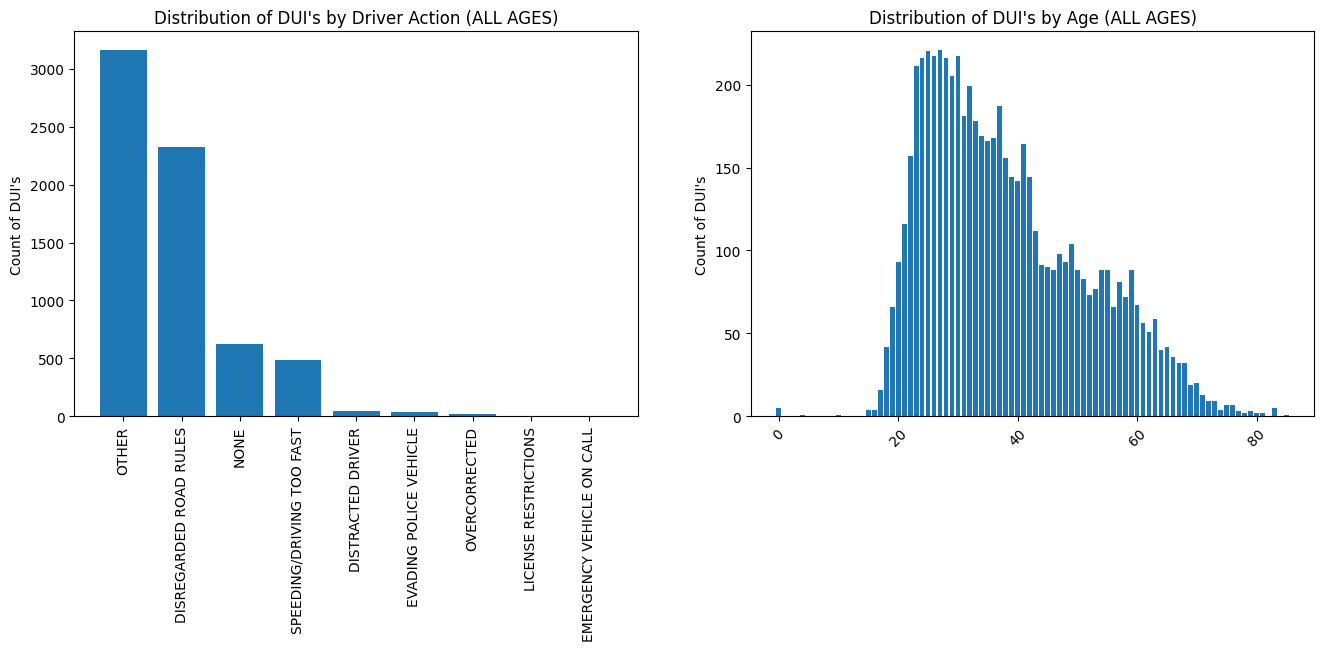

In [184]:
# set up plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

# create variables for easier reuse
DRIVER_ACTION_counts = df_master_dui_2018_2023['DRIVER_ACTION'].value_counts()
AGE_counts = df_master_dui_2018_2023['AGE'].value_counts()

# plot data
ax1.bar(DRIVER_ACTION_counts.index, DRIVER_ACTION_counts.values)
ax2.bar(AGE_counts.index, AGE_counts.values)

# customize appearance
ax1.tick_params(axis="x", labelrotation=90)
ax2.tick_params(axis="x", labelrotation=45)
ax1.set_ylabel("Count of DUI's")
ax2.set_ylabel("Count of DUI's")
ax1.set_title("Distribution of DUI's by Driver Action (ALL AGES)")
ax2.set_title("Distribution of DUI's by Age (ALL AGES)");

####Filtering for crashes involving serious injuries/fatalities

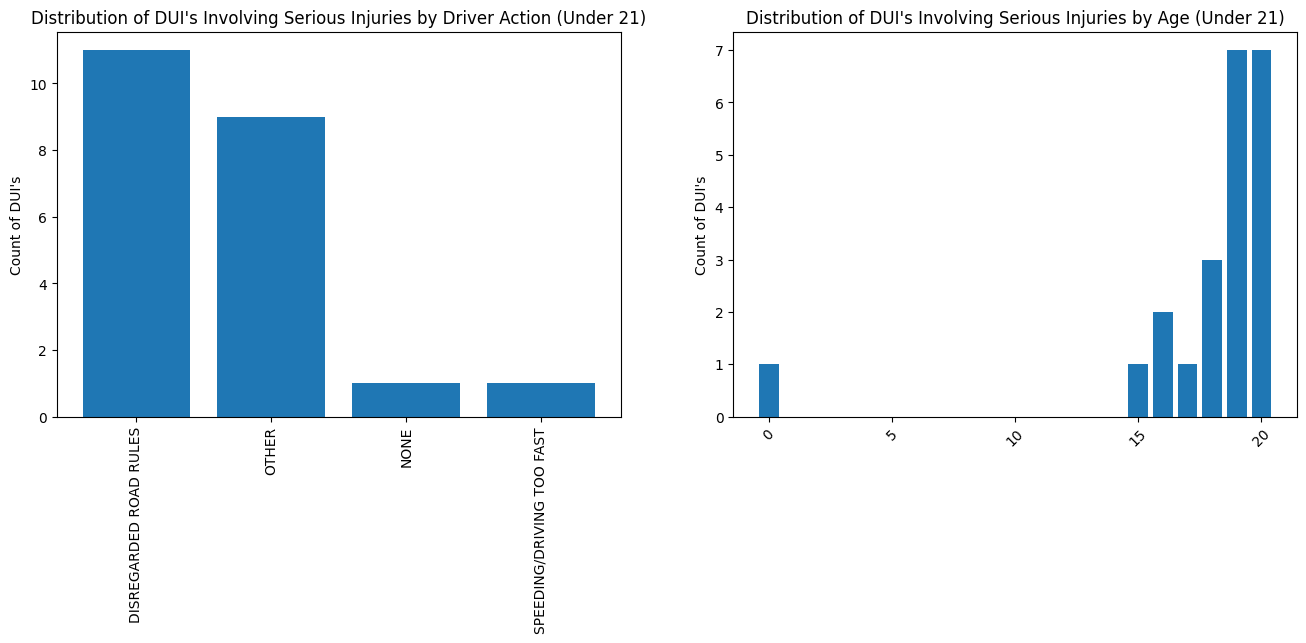

In [185]:
# set up plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

# Filter the data by ages under 21
filtered_injuries_under_21 = df_master_dui_2018_2023[
    (df_master_dui_2018_2023['AGE'] < 21) &
    (df_master_dui_2018_2023['Has_Serious_Injury'] == 1)]


# create variables for easier reuse
DRIVER_ACTION_counts = filtered_injuries_under_21['DRIVER_ACTION'].value_counts()
AGE_counts = filtered_injuries_under_21['AGE'].value_counts()

# plot data
ax1.bar(DRIVER_ACTION_counts.index, DRIVER_ACTION_counts.values)
ax2.bar(AGE_counts.index, AGE_counts.values)

# customize appearance
ax1.tick_params(axis="x", labelrotation=90)
ax2.tick_params(axis="x", labelrotation=45)
ax1.set_ylabel("Count of DUI's")
ax2.set_ylabel("Count of DUI's")
ax1.set_title("Distribution of DUI's Involving Serious Injuries by Driver Action (Under 21)")
ax2.set_title("Distribution of DUI's Involving Serious Injuries by Age (Under 21)");

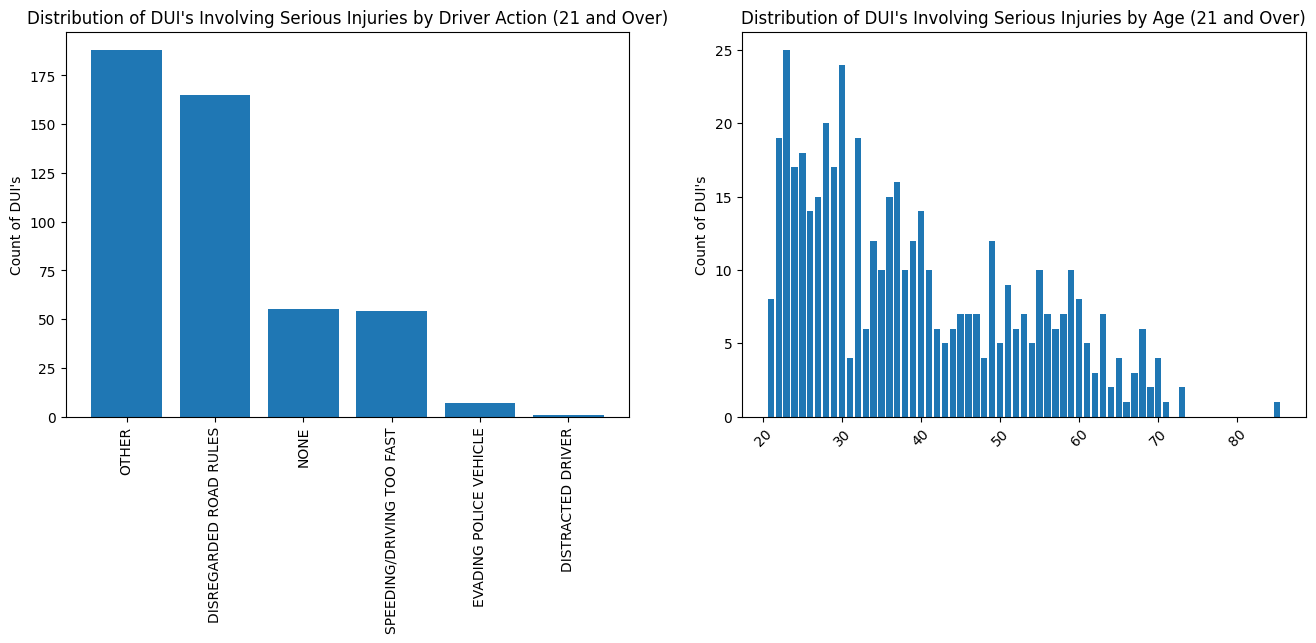

In [186]:
# set up plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

# Filter the data by ages 21 and over
filtered_injuries_under_21 = df_master_dui_2018_2023[
    (df_master_dui_2018_2023['AGE'] >= 21) &
    (df_master_dui_2018_2023['Has_Serious_Injury'] == 1)]


# create variables for easier reuse
DRIVER_ACTION_counts = filtered_injuries_under_21['DRIVER_ACTION'].value_counts()
AGE_counts = filtered_injuries_under_21['AGE'].value_counts()

# plot data
ax1.bar(DRIVER_ACTION_counts.index, DRIVER_ACTION_counts.values)
ax2.bar(AGE_counts.index, AGE_counts.values)

# customize appearance
ax1.tick_params(axis="x", labelrotation=90)
ax2.tick_params(axis="x", labelrotation=45)
ax1.set_ylabel("Count of DUI's")
ax2.set_ylabel("Count of DUI's")
ax1.set_title("Distribution of DUI's Involving Serious Injuries by Driver Action (21 and Over)")
ax2.set_title("Distribution of DUI's Involving Serious Injuries by Age (21 and Over)");

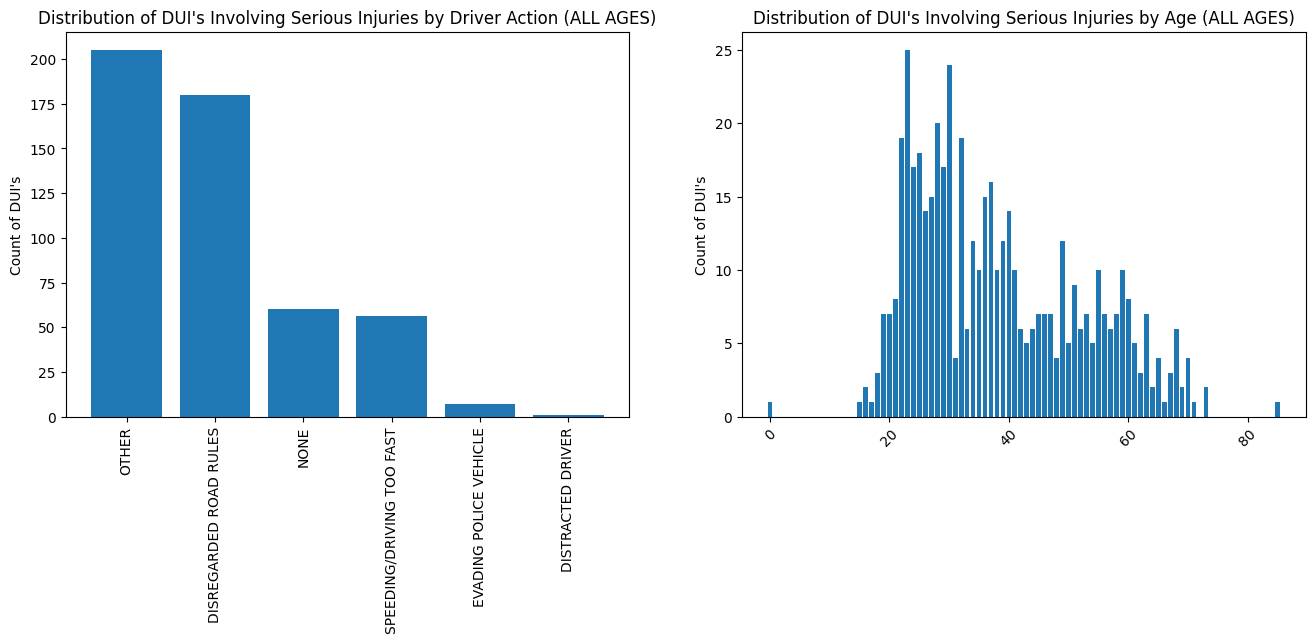

In [187]:
# set up plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

# Filter the data by ages 21 and over
filtered_injuries_under_21 = df_master_dui_2018_2023[(df_master_dui_2018_2023['Has_Serious_Injury'] == 1)]


# create variables for easier reuse
DRIVER_ACTION_counts = filtered_injuries_under_21['DRIVER_ACTION'].value_counts()
AGE_counts = filtered_injuries_under_21['AGE'].value_counts()

# plot data
ax1.bar(DRIVER_ACTION_counts.index, DRIVER_ACTION_counts.values)
ax2.bar(AGE_counts.index, AGE_counts.values)

# customize appearance
ax1.tick_params(axis="x", labelrotation=90)
ax2.tick_params(axis="x", labelrotation=45)
ax1.set_ylabel("Count of DUI's")
ax2.set_ylabel("Count of DUI's")
ax1.set_title("Distribution of DUI's Involving Serious Injuries by Driver Action (ALL AGES)")
ax2.set_title("Distribution of DUI's Involving Serious Injuries by Age (ALL AGES)");

####Visualizing `AGE` and `CRASH_HOUR` after filtering for people with serious injuries.

The chart shows serious accidents involving impaired drivers between peak late night/early A.M., especially between 1 and 2 A.M.

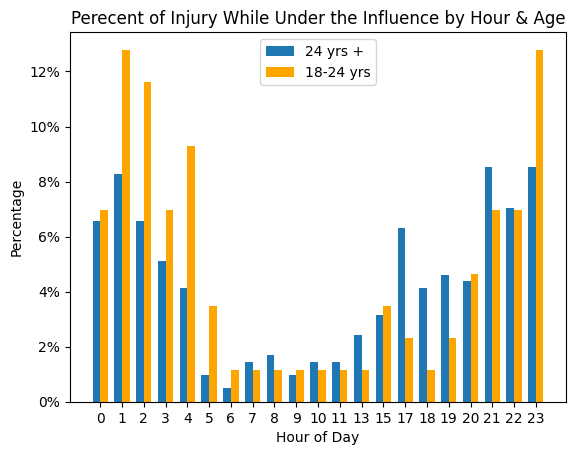

In [188]:
# Filter the data by ages 18-24
filtered_injuries_24plus = df_master_dui_2018_2023[
    (df_master_dui_2018_2023['AGE'] > 24) &
    (df_master_dui_2018_2023['Has_Serious_Injury'] == 1)]

# count of injuries by the hour of the day for 24 years and older
age_hour_injury_counts_24plus = filtered_injuries_24plus['CRASH_HOUR'].value_counts().sort_index()
age_hour_total_counts_24plus = age_hour_injury_counts_24plus.sum()
age_hour_injury_percentage_24plus = (age_hour_injury_counts_24plus / age_hour_total_counts_24plus) * 100

# Filter the data by ages 18-24
filtered_injuries_18to24 = df_master_dui_2018_2023[
    (df_master_dui_2018_2023['AGE'] >= 18) &
    (df_master_dui_2018_2023['AGE'] <= 24) &
    (df_master_dui_2018_2023['Has_Serious_Injury'] == 1)]

# count of injuries by the hour of the day (18-24 years old)
age_hour_injury_counts_18to24 = filtered_injuries_18to24['CRASH_HOUR'].value_counts().sort_index()
age_hour_total_counts_18to24 = age_hour_injury_counts_18to24.sum()
age_hour_injury_percentage_18to24 = (age_hour_injury_counts_18to24 / age_hour_total_counts_18to24) * 100

# Sort the indices so they appear correctly in the graph
age_hour_injury_percentage_24plus = age_hour_injury_percentage_24plus.reindex(age_hour_injury_percentage_18to24.index)
age_hour_injury_percentage_18to24 = age_hour_injury_percentage_18to24.reindex(age_hour_injury_percentage_24plus.index)

# Combine the x-values and adjust the positions for clustering
x_values = np.arange(len(age_hour_injury_percentage_24plus))
bar_width = 0.35

# Create the clustered bar chart
fig, ax = plt.subplots()
rects1 = ax.bar(x_values - bar_width/2, age_hour_injury_percentage_24plus, bar_width, label='24 yrs +')
rects2 = ax.bar(x_values + bar_width/2, age_hour_injury_percentage_18to24, bar_width, label='18-24 yrs', color='orange')

# plot
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Percentage')
ax.set_title('Perecent of Injury While Under the Influence by Hour & Age')
ax.legend()

yticks = mtick.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(yticks)

ax.set_xticks(x_values)
ax.set_xticklabels(age_hour_injury_percentage_24plus.index)

plt.show();

#Model Iterations — Baseline

We want to focus on eliminating false negatives. Our stakeholder is in agreement with their ethos being no crash is an accident and every crash-related death is preventable. Therefore, our primary metric will be recall. But first, we will run some different baseline models to use for comparison.

In [189]:
#Function for evaluation metrics
def print_binary_evaluation(X_train, X_test,y_train, y_true, strategy):
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(X_train, y_train)
    y_pred = dummy_clf.predict(X_test)
    results_dict = {'accuracy': accuracy_score(y_true, y_pred),
                    'recall': recall_score(y_true, y_pred),
                    'precision': precision_score(y_true, y_pred),
                    'f1_score': f1_score(y_true, y_pred)}
    return results_dict

###Perform Train-Test Split

In [190]:
# Seperate features from target
X = df.drop("Has_Serious_Injury", axis=1)
y = df['Has_Serious_Injury']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

###Most Frequent (Mode) Baseline Model
####By predicting 0 all the time, our model would be ~ 98% acurate.  

In [191]:
print_binary_evaluation(X_train, X_test, y_train, y_test, 'most_frequent')

{'accuracy': 0.9757936086633401,
 'recall': 0.0,
 'precision': 0.0,
 'f1_score': 0.0}

In [ ]:
# 0 is obviously the most frequent value
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(list(y_pred))

###Uniform Baseline Model

####Uniform strategy creates a baseline model that predicts with random uniform distribution. The targets have a similar probability of being a prediction output.

In [192]:
print_binary_evaluation(X_train, X_test,y_train, y_test, 'uniform')

{'accuracy': 0.5008205299319005,
 'recall': 0.4986215538847118,
 'precision': 0.02418256958794214,
 'f1_score': 0.046127985161140736}

In [ ]:
# Uniform gives us more of a 50/50 split
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(list(y_pred))

###Stratified Baseline Model
#### Stratified strategy creates a baseline model that follows the target distribution. It is suitable for imbalanced data as it reflects the actual distribution.

In [194]:
print_binary_evaluation(X_train, X_test,y_train, y_test, 'stratified')

{'accuracy': 0.9522515280663704,
 'recall': 0.021929824561403508,
 'precision': 0.021575638022438663,
 'f1_score': 0.021751289540737056}

In [ ]:
# 0 dominates as ~ 98% of our target variable == 0
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(list(y_pred))

###The Uniform Baseline Model provided the closest results to our goal, while still far short of it, having just a 50% recall.



```
{'accuracy': 0.5008205299319005,
 'recall': 0.4986215538847118,
 'precision': 0.02418256958794214,
 'f1_score': 0.046127985161140736}
```



##Investigating feature target relationships with `dabl`
Documentation: https://dabl.github.io/stable/

 The dabl plots are in alignment with features we noted during EDA: `CRASH_HOUR`, `PERSON_TYPE`, `CRASH_TYPE`, `DRIVER_ACTION`, `AGE`, `PHYSICAL_CONDITION`, `DRIVER_VISION`, `LIGHTING_CONDITION`, `POSTED_SPEED_LIMIT`, `PRIM_CONTRIBUTORY_CAUSE`, as well as some of the aggregate and boolean features we created like `is_driver` and `total_drivers_in_crash`.

In [198]:
# full master dataset
data1 = pd.read_csv(dabl.datasets.data_path("/content/gdrive/MyDrive/Colab Notebooks/Phase3-Project-Data/df.csv"))

In [200]:
# filtered for impaired only
data2 = pd.read_csv(dabl.datasets.data_path("/content/gdrive/MyDrive/Colab Notebooks/Phase3-Project-Data/df_master_dui_2018_2023.csv"))

In [201]:
# dropping junk column
data1.drop(columns=(['Unnamed: 0']), inplace=True)
data2.drop(columns=(['Unnamed: 0']), inplace=True)

###Feature relationships with target using master df with all people (impaired and not impaired)

Target looks like classification
Linear Discriminant Analysis training set score: 0.597


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='Has_Serious_Injury'>,
 [<Figure size 1600x400 with 8 Axes>,
  array([[<Axes: title={'center': '0.523'}, xlabel='INJURIES_TOTAL', ylabel='CRASH_HOUR(jittered)'>,
          <Axes: title={'center': '0.520'}, xlabel='INJURIES_TOTAL', ylabel='AGE'>,
          <Axes: title={'center': '0.511'}, xlabel='INJURIES_TOTAL', ylabel='LATITUDE'>,
          <Axes: title={'center': '0.509'}, xlabel='INJURIES_TOTAL', ylabel='CRASH_DAY_OF_WEEK(jittered)'>]],
        dtype=object),
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 640x480 with 1 Axes>],
 array([[<Axes: title={'center': 'MOST_SEVERE_INJURY'}>,
         <Axes: title={'center': 'INJURY_CLASSIFICATION'}>,
         <Axes: title={'center': 'CRASH_TYPE'}>,
         <Axes: title={'center': 'HOSPITAL'}>,
         <Axes: title={'center': 'PERSON_TYPE'}>],
        [<Axes: title={'center': 'total_drivers_in_crash'}>,
         <Axes: title={'center': 'PHYSICAL_CONDITION'}>,
  

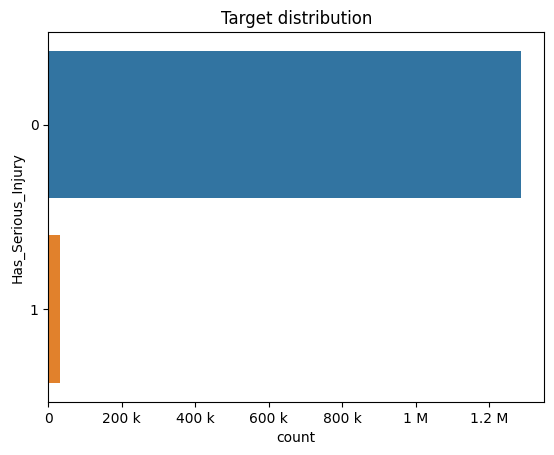

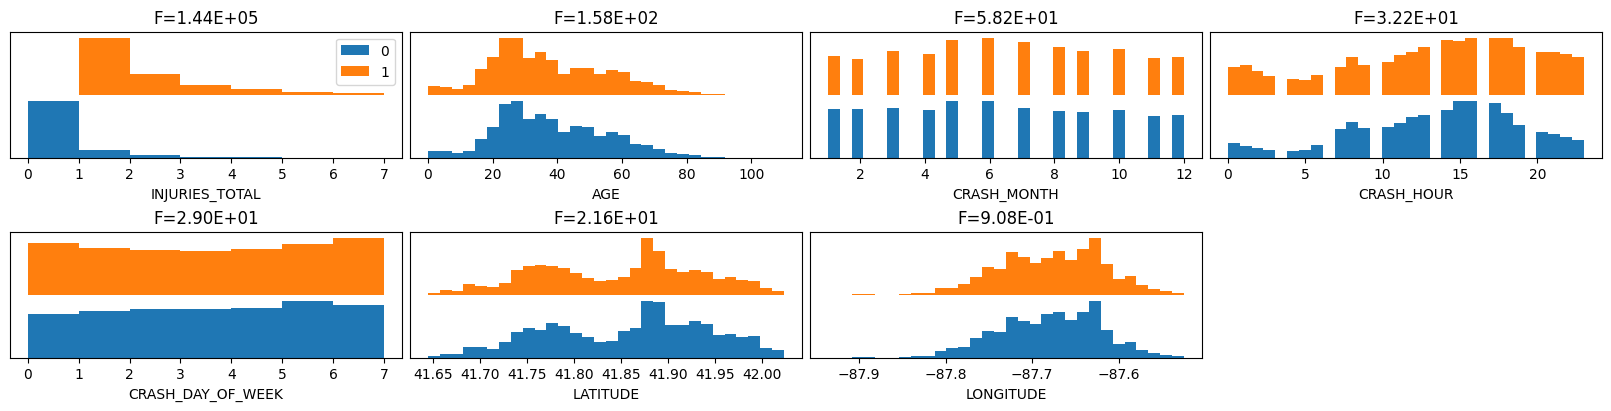

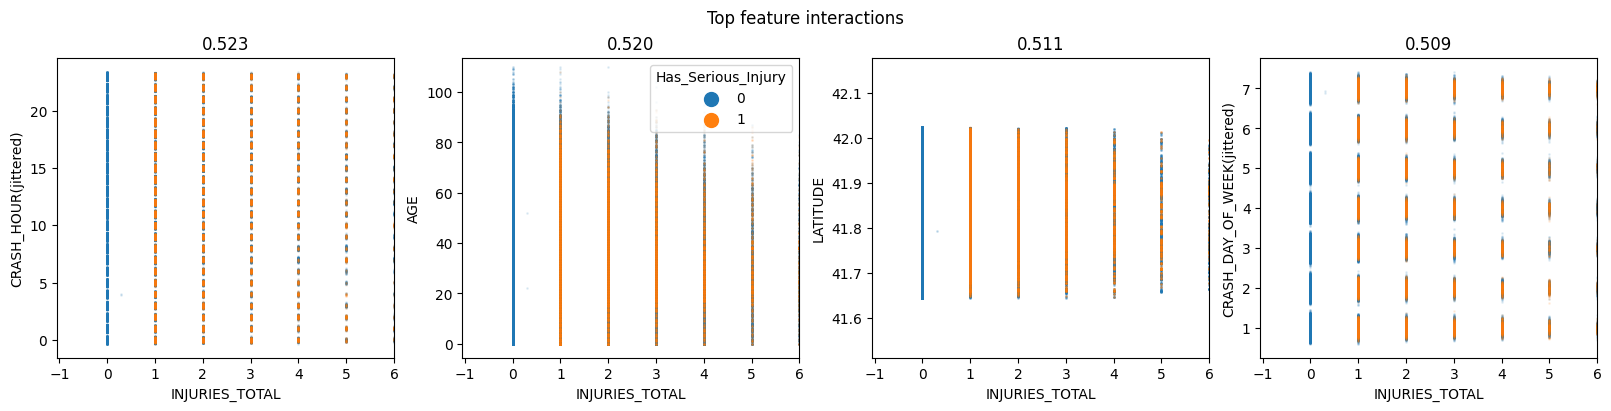

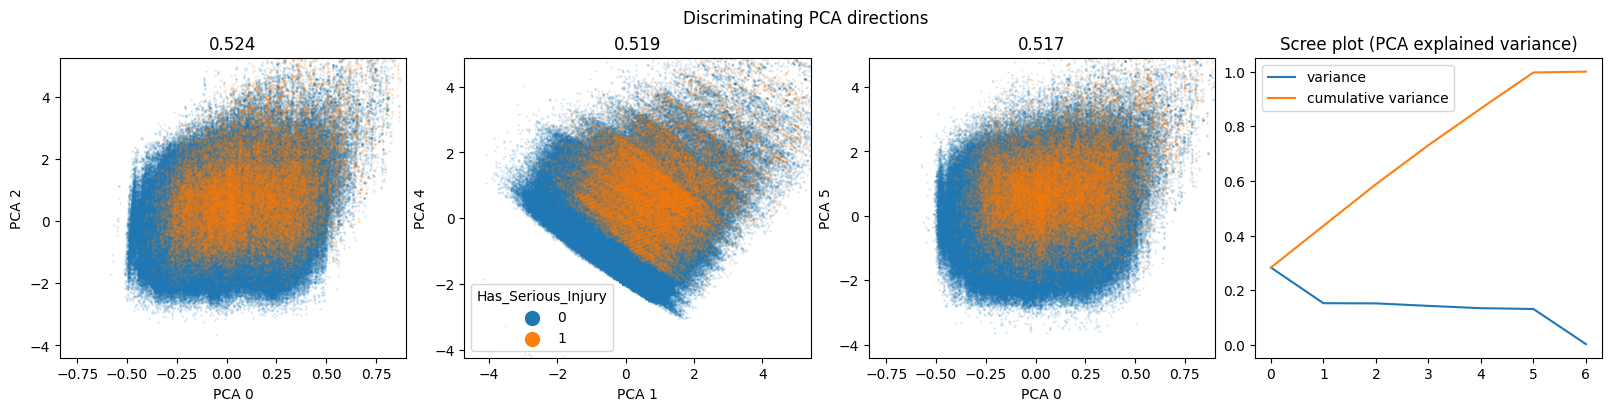

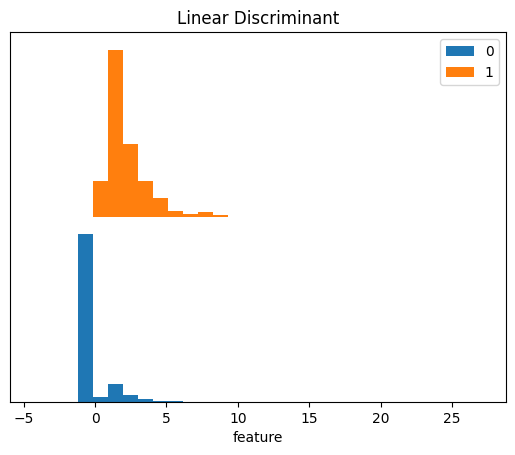

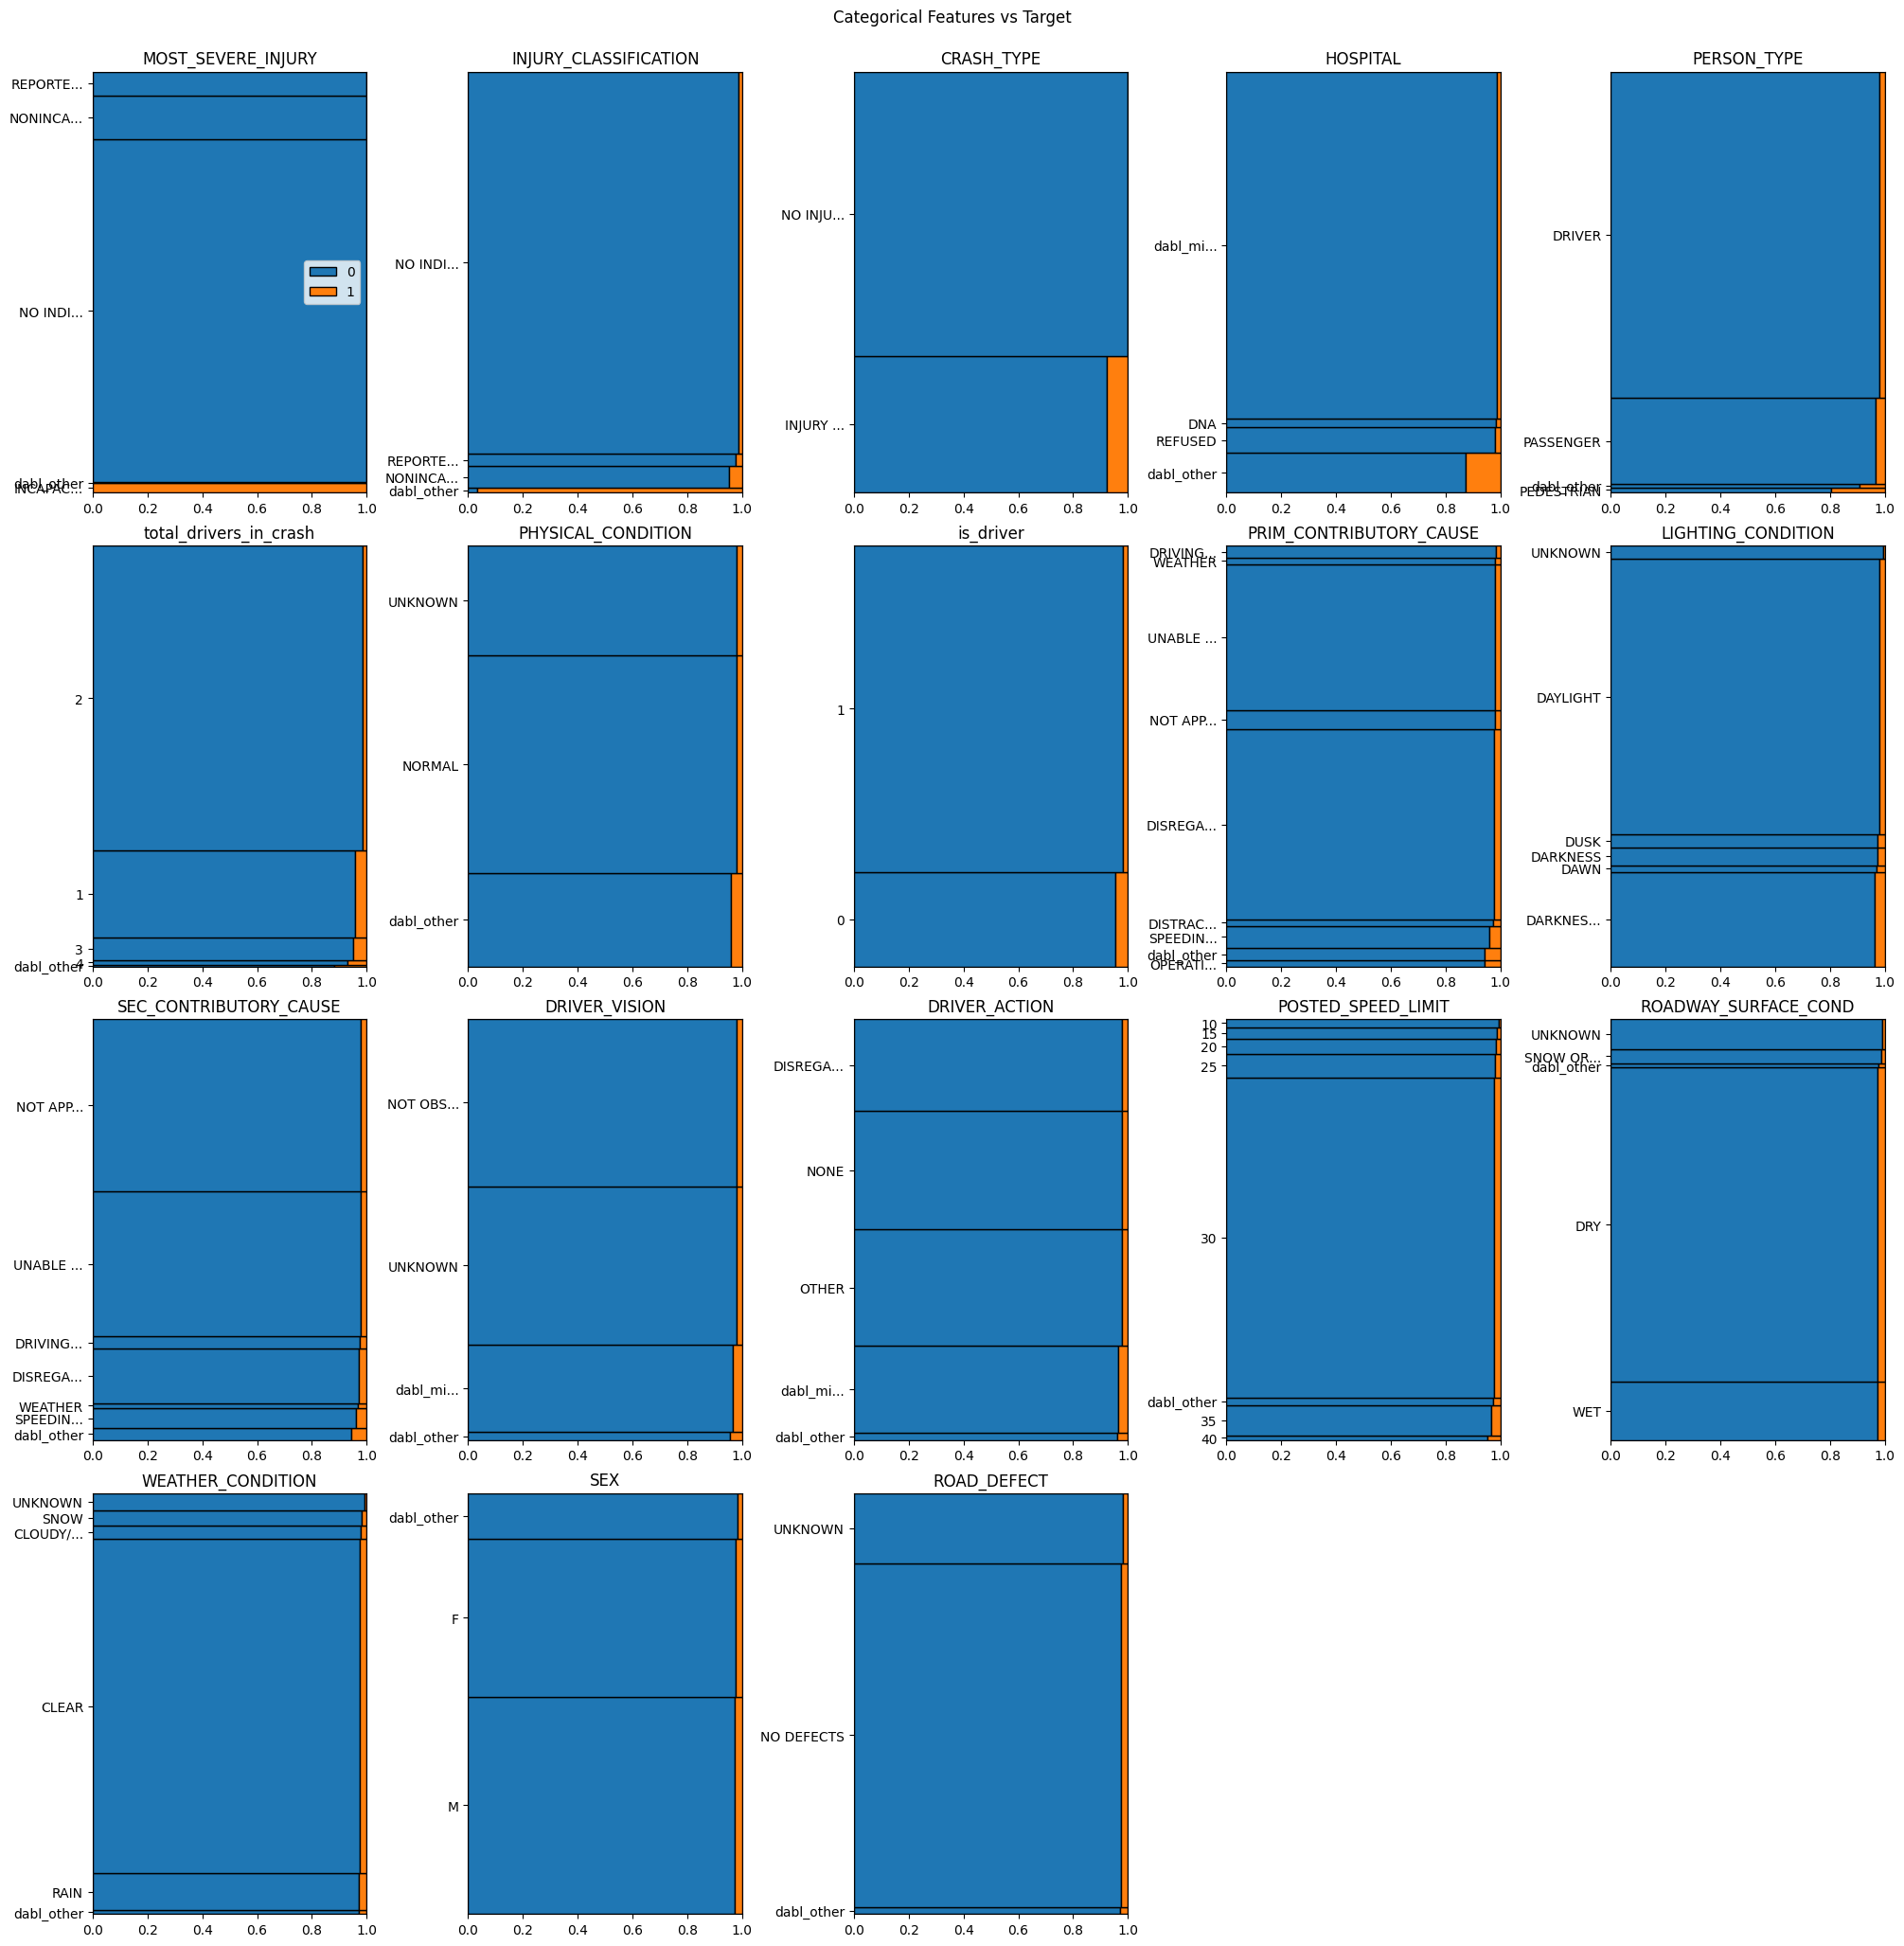

In [202]:
dabl.plot(data1, target_col="Has_Serious_Injury")

###Feature relationships with target using impaired-only dataset

Target looks like classification
Linear Discriminant Analysis training set score: 1.000


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='Has_Serious_Injury'>,
 [<Figure size 1600x600 with 12 Axes>,
  array([[<Axes: title={'center': '1.000'}, xlabel='Total_Serious_Inj...(jittered)', ylabel='INJURIES_INCAPACI...(jittered)'>,
          <Axes: title={'center': '1.000'}, xlabel='Total_Serious_Inj...(jittered)', ylabel='LONGITUDE'>,
          <Axes: title={'center': '1.000'}, xlabel='Total_Serious_Inj...(jittered)', ylabel='AGE'>,
          <Axes: title={'center': '1.000'}, xlabel='Total_Serious_Inj...(jittered)', ylabel='CRASH_DAY_OF_WEEK(jittered)'>]],
        dtype=object),
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 640x480 with 1 Axes>],
 array([[<Axes: title={'center': 'MOST_SEVERE_INJURY'}>,
         <Axes: title={'center': 'INJURY_CLASSIFICATION'}>,
         <Axes: title={'center': 'CRASH_TYPE'}>,
         <Axes: title={'center': 'PERSON_TYPE'}>,
         <Axes: title={'center': 'is_driver'}>],
        [<Axes: title={'center': 'PRIM_CONT

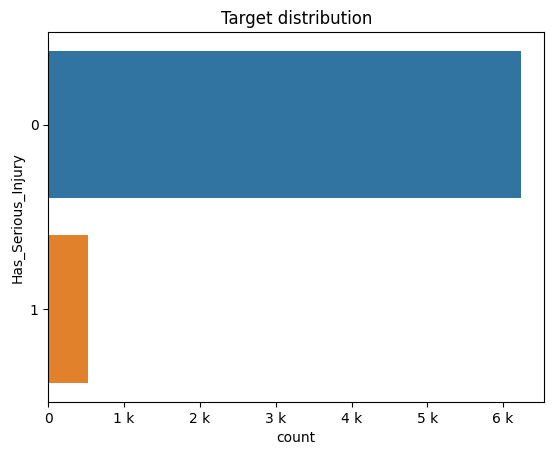

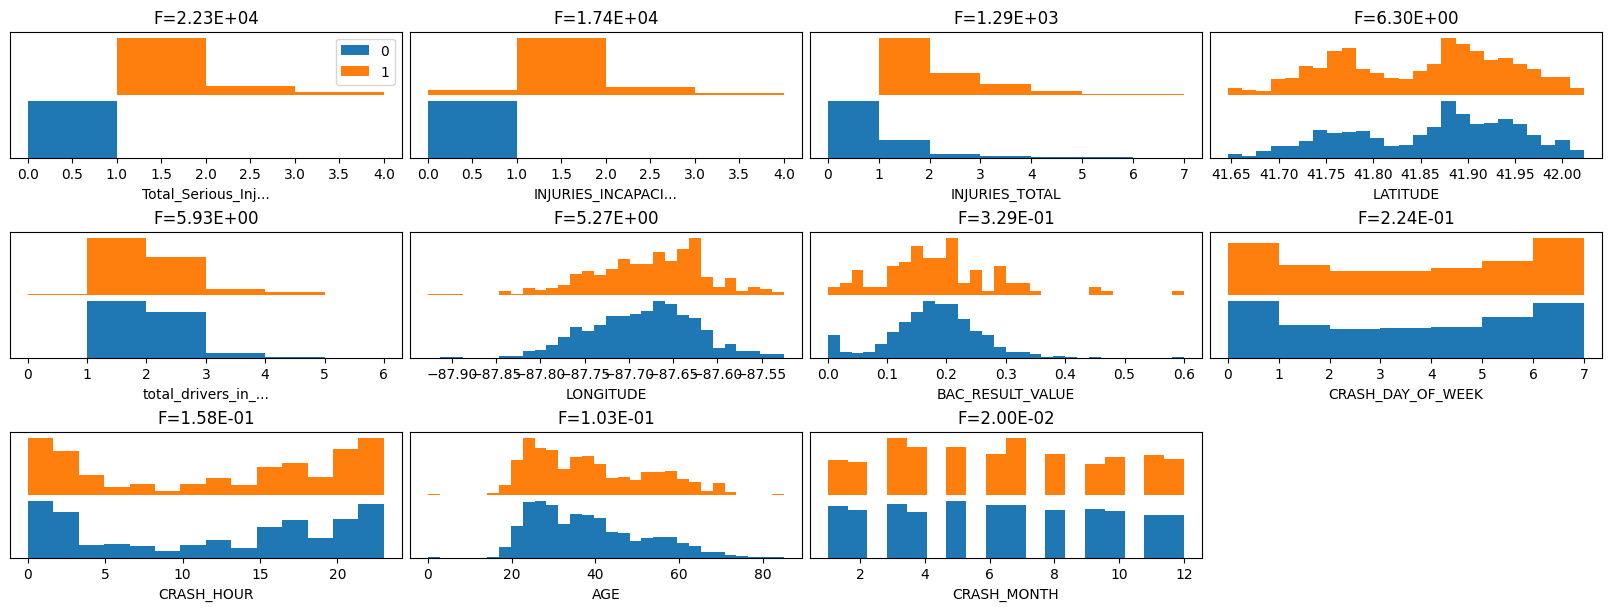

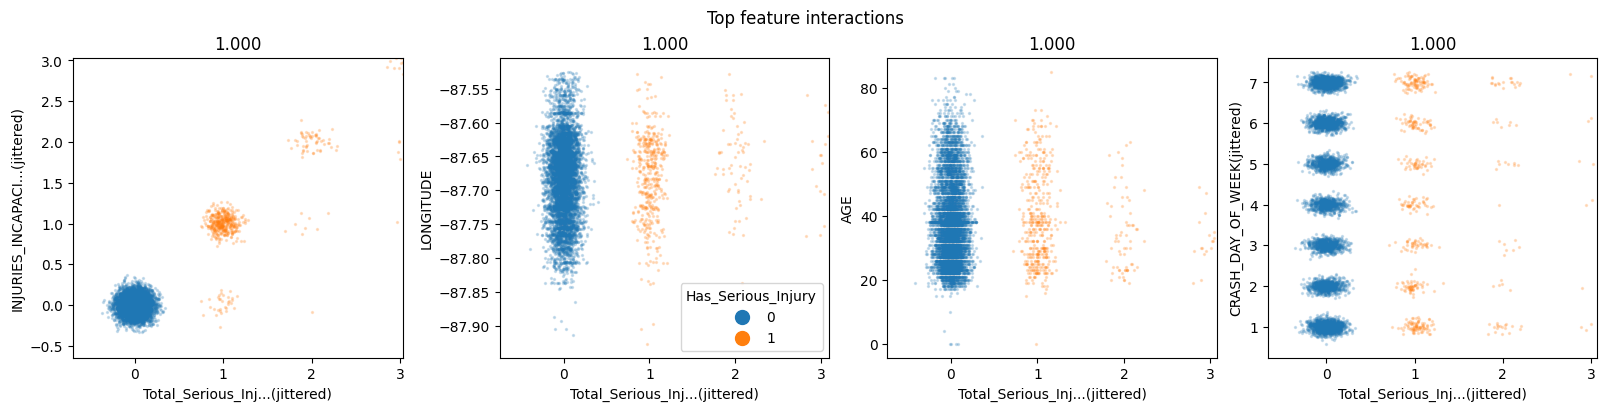

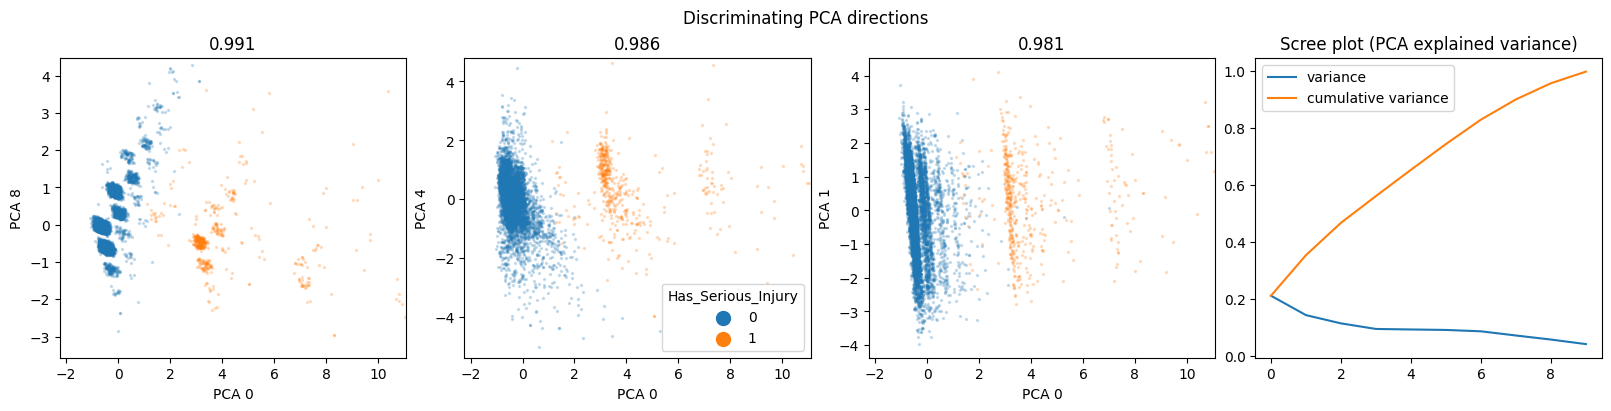

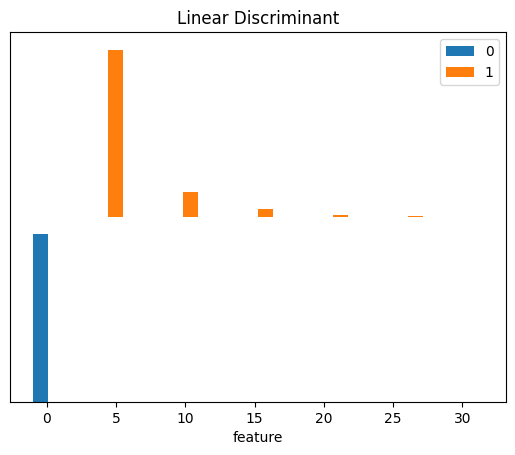

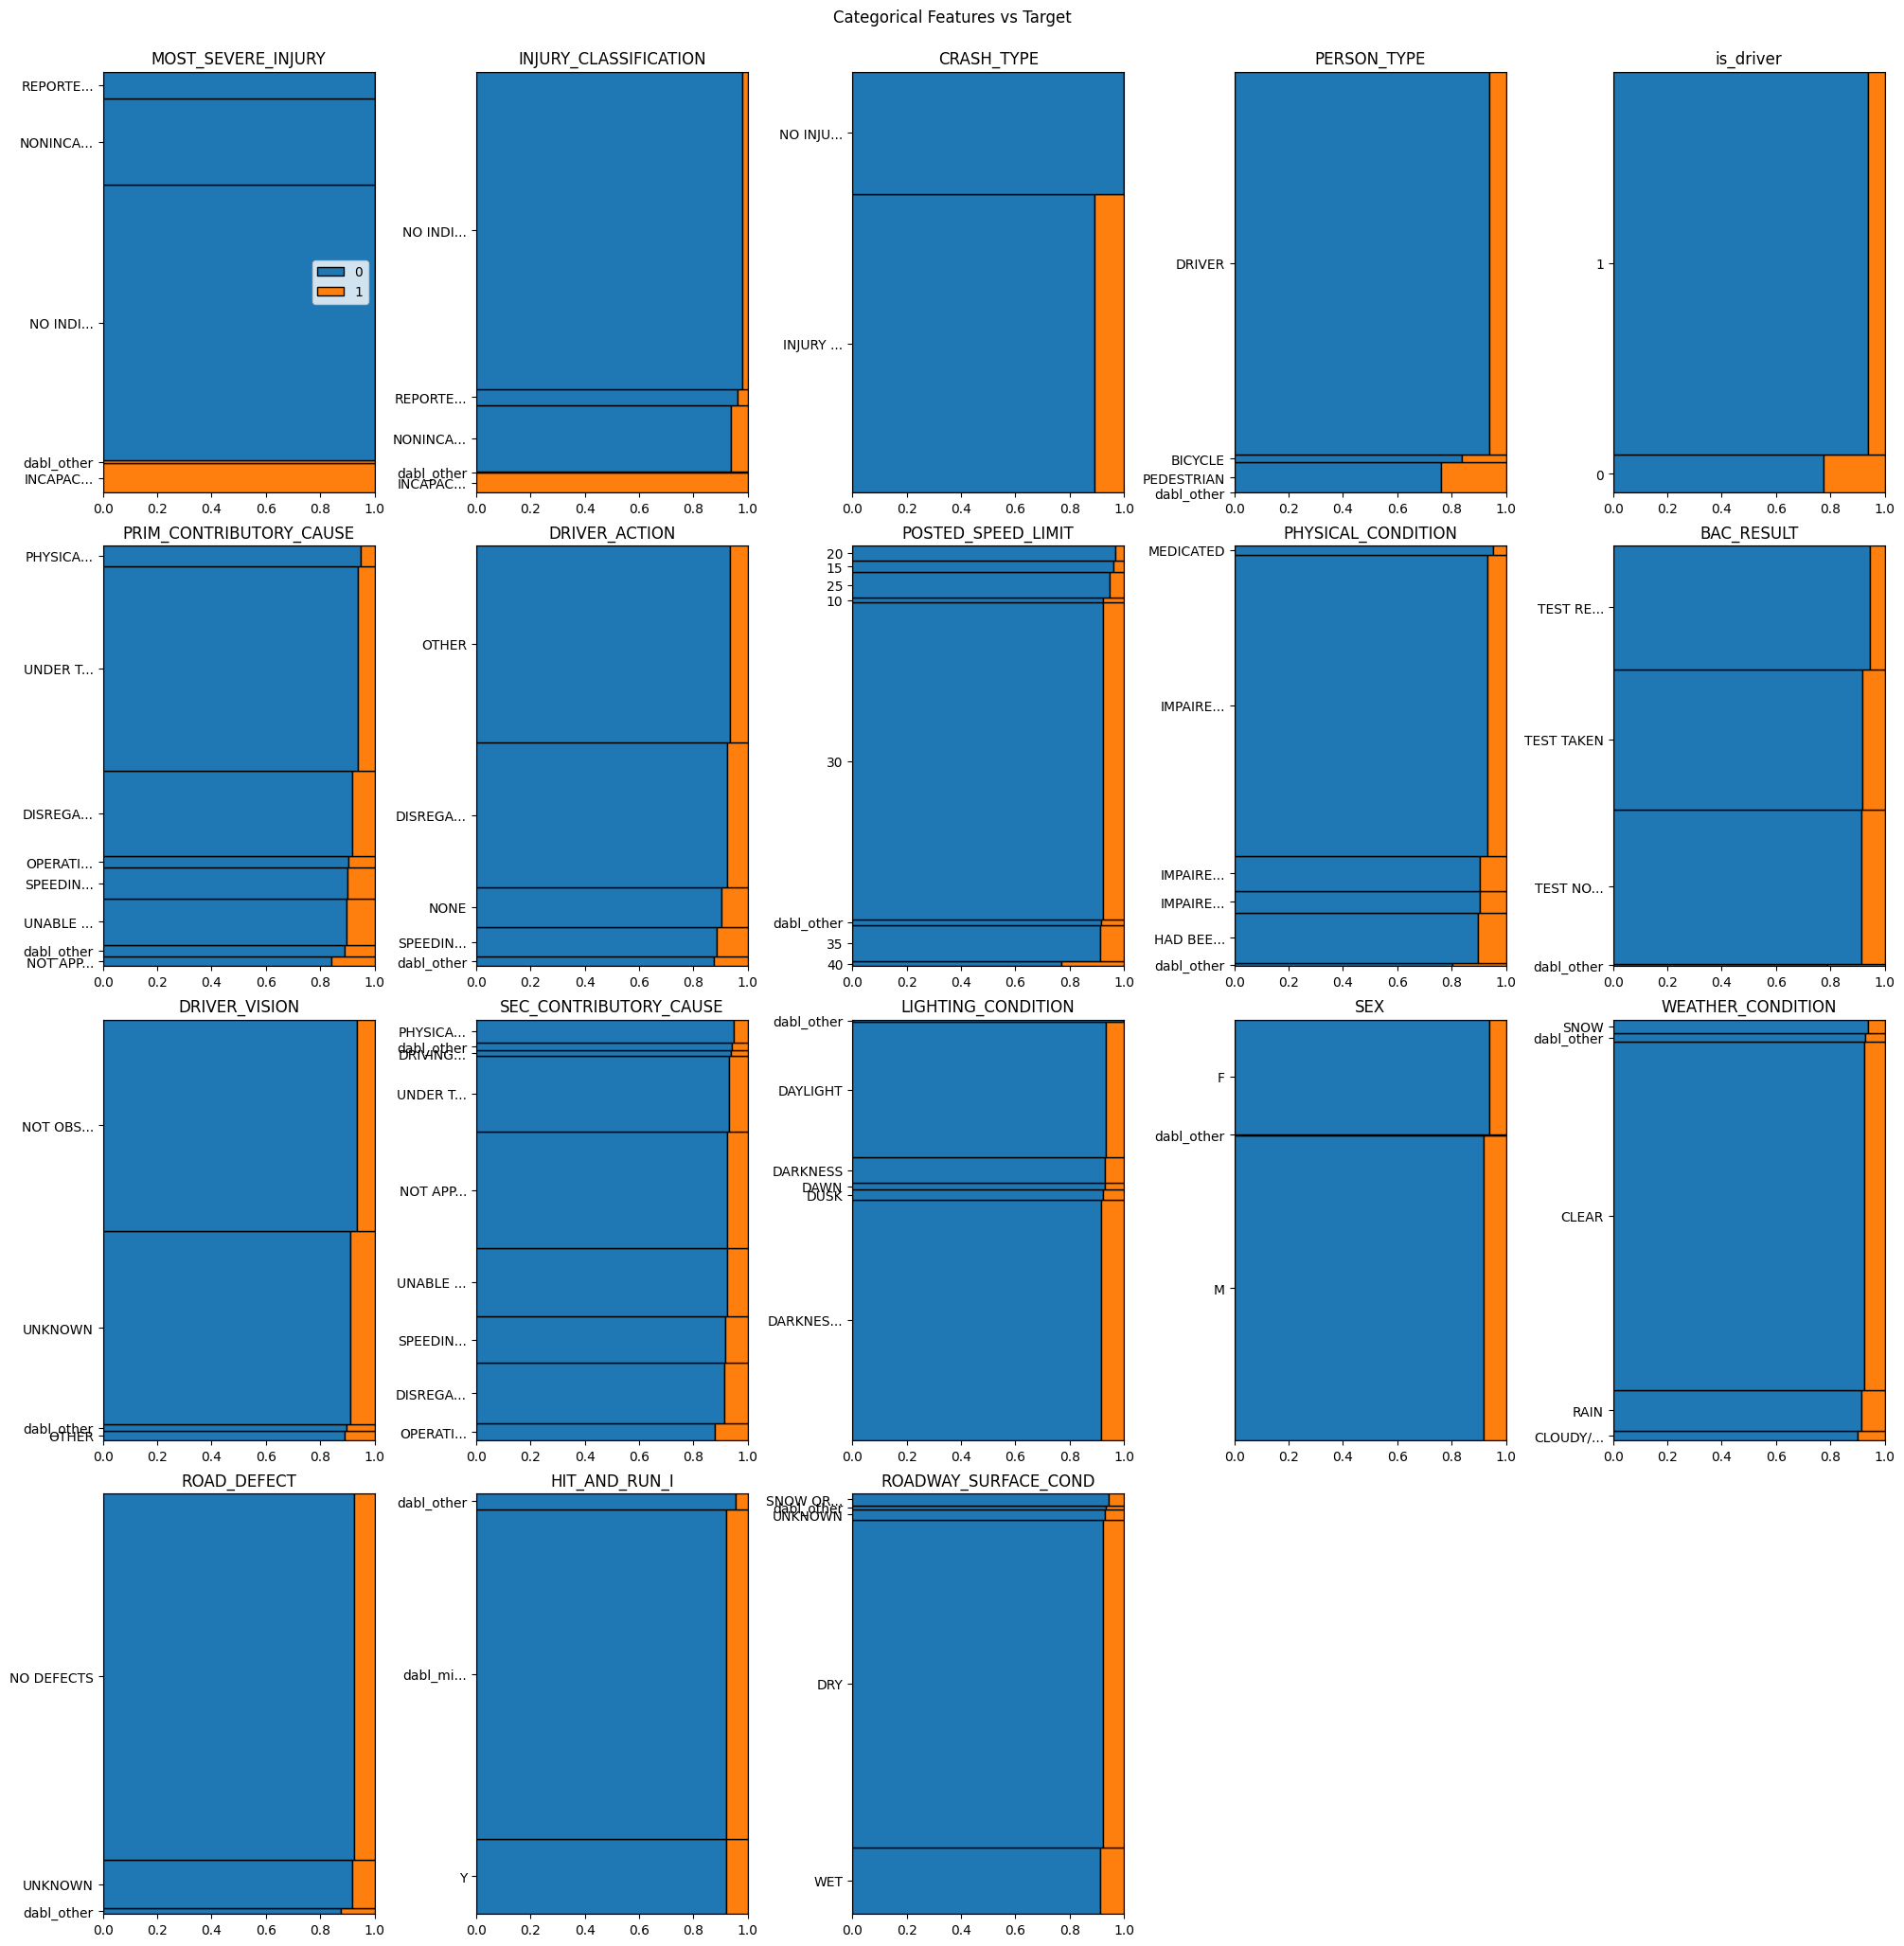

In [203]:
dabl.plot(data2, target_col="Has_Serious_Injury")

#Model Iterations — Decision Tree, Random Forest, Logistic Regression

##Model Iteration 1: Decision Tree

In [206]:
#Separate our X and y variables
y=df['Has_Serious_Injury']
X=df[['PERSON_TYPE', 'AGE','CRASH_HOUR', 'Under_Influence']]

In [207]:
#Train test split
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=10)

In [208]:
# Impute missing AGE data using MICE

# Identify data to be transformed
age_train = X_train[["AGE"]]

# (1) Instantiate Imputer
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=10,n_nearest_features=5)

# (2) Fit the imputer on age_train
imputer.fit(age_train)

# (3) Transform age_train using the imputer and
# assign the result to age_imputed_train
age_imputed_train = imputer.transform(age_train)
age_imputed_test = imputer.transform(X_test[["AGE"]])

# (4) Replace value of AGE
X_train["AGE"] = age_imputed_train.round()
X_test["AGE"] = age_imputed_test.round()

In [209]:
# (1) Create variables
# (double brackets due to shape expected by OHE)
person_type_train = X_train[["PERSON_TYPE"]]
person_type_test = X_test[["PERSON_TYPE"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe = OneHotEncoder(categories="auto", sparse_output=False, handle_unknown="ignore")

# (3) Fit the encoder on training data
ohe.fit(person_type_train)

# (4) Transform data and assign variables
person_type_encoded_train = ohe.transform(person_type_train)
person_type_encoded_test = ohe.transform(person_type_test)

# (5a) Make the transformed data into a dataframe
person_type_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    person_type_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)
person_type_encoded_test= pd.DataFrame(
    # Pass in NumPy array
    person_type_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# (5b) Drop original PERSON_TYPE column
X_train.drop("PERSON_TYPE", axis=1, inplace=True)
X_test.drop("PERSON_TYPE", axis=1, inplace=True)
# (6) merge
X_train = pd.concat([X_train, person_type_encoded_train], axis=1)
X_test = pd.concat([X_test, person_type_encoded_test], axis=1)

In [210]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(random_state = 10)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 24277
Before OverSampling, counts of label '0': 964717 

After OverSampling, the shape of train_X: (1929434, 9)
After OverSampling, the shape of train_y: (1929434,) 

After OverSampling, counts of label '1': 964717
After OverSampling, counts of label '0': 964717


In [211]:
# Instantiate and fit decision tree model
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=10)
# train the model
tree_clf.fit(X_train_res, y_train_res)

DecisionTreeClassifier(max_depth=3, random_state=10)

In [212]:
# get predictions
y_pred = tree_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(acc))

# Precision
precision = precision_score(y_test, y_pred)
print("Precision: {0}".format(precision))

# Recall
recall = recall_score(y_test, y_pred)
print("Recall: {0}".format(recall))

# F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {0}".format(f1))

Accuracy: 70.92715332231204
Precision: 0.04198421551966804
Recall: 0.5046365914786968
F1 Score: 0.07751908139792295


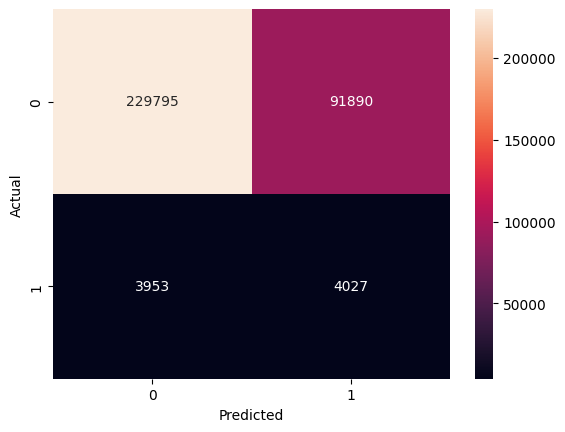

In [213]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

We have made some improvements from our Uniform Baseline Model, but we require a better recall than either.


```
# Baseline:
Accuracy: 50.08205299319005
Precision: 2.418256958794214
Recall: 0.4986215538847118
F1: 0.046127985161140736
```


```
# Decision Tree
Accuracy: 70.92715332231204
Precision: 4.198421551966804
Recall: 0.5046365914786968
F1: 0.07751908139792295
```


Next, we defined a function for fitting trees of various depths on the training data using cross-validation, which recommended a `max-depth=1`. We ran multiple decision tree models with this recommended depth, experimented with different features, and undersampling vs. oversampling. However, none of these iterations gave us a better result than our Random Forest Model.  


##Model Iteration 2 — Random Forest

In [396]:
#Separate our X and y variables
y=df['Has_Serious_Injury']
X=df[['PERSON_TYPE', 'SEX', 'AGE',
       'DRIVER_ACTION', 'BAC_RESULT', 'BAC_RESULT_VALUE',
       'is_driver', 'total_drivers_in_crash',
       'CRASH_HOUR', 'POSTED_SPEED_LIMIT', 'LIGHTING_CONDITION',
      'CRASH_TYPE','Under_Influence']]

In [397]:
#Train test split
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=10)

####Handling missing values

In [398]:
# (1) Identify data to be transformed
action_train = X_train[["DRIVER_ACTION"]]
action_test = X_test[["DRIVER_ACTION"]]

# (2) Instantiate the transformer object
missing_indicator = MissingIndicator()

# (3) Fit the transformer object
missing_indicator.fit(action_train)

# (4) Transform data and assign variables
action_missing_train = missing_indicator.transform(action_train)
action_missing_test =  missing_indicator.transform(action_test)

# (5) add the transformed data to the other data
X_train["ACTION_Missing"] = action_missing_train
X_test["ACTION_Missing"] = action_missing_test

# Replace "DRIVER_ACTION" nulls with MISSING
X_train["DRIVER_ACTION"].fillna("MISSING", inplace=True)
X_test["DRIVER_ACTION"].fillna("MISSING", inplace=True)

In [399]:
# Impute median BAC value when test was taken and result not recorded. If test was not offered impute 0
bac_median=X_train['BAC_RESULT_VALUE'].median()
X_train.loc[X_train['BAC_RESULT_VALUE'].isna(), 'BAC_RESULT_VALUE']=X_train['BAC_RESULT'].apply(lambda x: 0 if x=='TEST NOT OFFERED' else bac_median)
X_test.loc[X_test['BAC_RESULT_VALUE'].isna(), 'BAC_RESULT_VALUE']=X_test['BAC_RESULT'].apply(lambda x: 0 if x=='TEST NOT OFFERED' else bac_median)

# drop BAC RESULT column
X_train.drop("BAC_RESULT", axis=1, inplace=True)
X_test.drop("BAC_RESULT", axis=1, inplace=True)

In [400]:
# Impute missing sex values based on distribution of data.
n_males=X_train['SEX'].value_counts()['M']
n_females=X_train['SEX'].value_counts()['F']
def sex_fixer(x):
    r=random.randint(1, n_males+n_females)
    if r<=n_males:
        return 'M'
    else:
        return 'F'

X_train.loc[X_train['SEX'].isna(), 'SEX']=X_train.loc[X_train['SEX'].isna(), 'SEX'].apply(sex_fixer)
X_train.loc[X_train['SEX']=='X', 'SEX']=X_train.loc[X_train['SEX']=='X', 'SEX'].apply(sex_fixer)

X_test.loc[X_test['SEX'].isna(), 'SEX']=X_test.loc[X_test['SEX'].isna(), 'SEX'].apply(sex_fixer)
X_test.loc[X_test['SEX']=='X', 'SEX']=X_test.loc[X_test['SEX']=='X', 'SEX'].apply(sex_fixer)

In [401]:
# create a record of missing AGE data
# (1) Identify data to be transformed
age_train = X_train[["AGE"]]
age_test = X_test[["AGE"]]

# (2) Instantiate the transformer object
missing_indicator = MissingIndicator()

# (3) Fit the transformer object on age_train
missing_indicator.fit(age_train)

# (4) Transform data and assign variables
age_missing_train = missing_indicator.transform(age_train)
age_missing_test = missing_indicator.transform(age_test)

# (5) add the transformed data to the other data
X_train["AGE_Missing"] = age_missing_train
X_test["AGE_Missing"] = age_missing_test

In [402]:
# Impute missing AGE data using MICE
# (1) Instantiate Imputer
imputer = IterativeImputer(imputation_order='ascending', max_iter=10, random_state=10, n_nearest_features=5)

# (2) Fit the imputer on age_train
imputer.fit(age_train)

# (3) Transform data and assign variables
age_imputed_train = imputer.transform(age_train)
age_imputed_test = imputer.transform(age_test)

# (4) Replace value of AGE in original X_train and X_test
X_train['AGE'] = age_imputed_train.round()
X_test['AGE'] = age_imputed_test.round()


####Encoding Categorical Variables

In [403]:
# (1) Create variables
# (double brackets due to shape expected by OHE)
person_type_train = X_train[["PERSON_TYPE"]]
person_type_test = X_test[["PERSON_TYPE"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe = OneHotEncoder(categories="auto", sparse_output=False, handle_unknown="ignore")

# (3) Fit the encoder on training data
ohe.fit(person_type_train)

# (4) Transform data and assign variables
person_type_encoded_train = ohe.transform(person_type_train)
person_type_encoded_test = ohe.transform(person_type_test)

# (5a) Make the transformed data into a dataframe
person_type_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    person_type_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)
person_type_encoded_test= pd.DataFrame(
    # Pass in NumPy array
    person_type_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# (5b) Drop original PERSON_TYPE column
X_train.drop("PERSON_TYPE", axis=1, inplace=True)
X_test.drop("PERSON_TYPE", axis=1, inplace=True)

# (6) merge
X_train = pd.concat([X_train, person_type_encoded_train], axis=1)
X_test = pd.concat([X_test, person_type_encoded_test], axis=1)

In [404]:
# (1) Create variables
# (double brackets due to shape expected by OHE)
crash_type_train = X_train[["CRASH_TYPE"]]
crash_type_test = X_test[["CRASH_TYPE"]]

# (2) Fit the encoder on training data
ohe.fit(crash_type_train)

# (3) Transform data and assign variables
crash_type_encoded_train = ohe.transform(crash_type_train)
crash_type_encoded_test = ohe.transform(crash_type_test)

# (4) Make the transformed data into a dataframe
crash_type_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    crash_type_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)
crash_type_encoded_test = pd.DataFrame(
    # Pass in NumPy array
    crash_type_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# (5) Drop original CRASH_TYPE column
X_train.drop("CRASH_TYPE", axis=1, inplace=True)
X_test.drop("CRASH_TYPE", axis=1, inplace=True)

# (6) merge
X_train = pd.concat([X_train, crash_type_encoded_train], axis=1)
X_test = pd.concat([X_test, crash_type_encoded_test], axis=1)

In [405]:
# (1) Create variables
# (double brackets due to shape expected by OHE)
driver_action_train = X_train[["DRIVER_ACTION"]]
driver_action_test = X_test[["DRIVER_ACTION"]]

# (2) Fit the encoder on training data
ohe.fit(driver_action_train)

# (3) Transform data and assign variables
driver_action_encoded_train = ohe.transform(driver_action_train)
driver_action_encoded_test = ohe.transform(driver_action_test)

# (4) Make the transformed data into a dataframe
driver_action_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    driver_action_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)

driver_action_encoded_test = pd.DataFrame(
    # Pass in NumPy array
    driver_action_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# (5) Drop original DRIVER_ACTION column
X_train.drop("DRIVER_ACTION", axis=1, inplace=True)
X_test.drop("DRIVER_ACTION", axis=1, inplace=True)

# (6) merge
X_train = pd.concat([X_train, driver_action_encoded_train], axis=1)
X_test = pd.concat([X_test, driver_action_encoded_test], axis=1)

In [406]:
# (1) Create variables
# (double brackets due to shape expected by OHE)
lighting_train = X_train[["LIGHTING_CONDITION"]]
lighting_test = X_test[["LIGHTING_CONDITION"]]

# (2) Fit the encoder on lighting_train
ohe.fit(lighting_train)

# (3) Transform data and assign variables
lighting_encoded_train = ohe.transform(lighting_train)
lighting_action_encoded_test = ohe.transform(lighting_test )

# (4) Make the transformed data into a dataframe
lighting_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    lighting_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)
lighting_action_encoded_test = pd.DataFrame(
    # Pass in NumPy array
    lighting_action_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# (5) Drop original LIGHTING_CONDITION column
X_train.drop("LIGHTING_CONDITION", axis=1, inplace=True)
X_test.drop("LIGHTING_CONDITION", axis=1, inplace=True)

# (6) merge
X_train = pd.concat([X_train, lighting_encoded_train], axis=1)
X_test = pd.concat([X_test, lighting_action_encoded_test], axis=1)

In [407]:
# (1) Create a variables
# (double brackets due to shape expected by OHE)
sex_train = X_train[["SEX"]]
sex_test = X_test[["SEX"]]

# (3) Fit the encoder on training data
ohe.fit(sex_train)

# (4) Transform data and assign variables
sex_encoded_train = ohe.transform(sex_train)
sex_encoded_test = ohe.transform(sex_test)

# (5) Make the transformed data into a dataframe
sex_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    sex_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)
sex_encoded_test = pd.DataFrame(
    # Pass in NumPy array
    sex_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# (5b) Drop original SEX column
X_train.drop("SEX", axis=1, inplace=True)
X_test.drop("SEX", axis=1, inplace=True)

# (6) merge
X_train = pd.concat([X_train, sex_encoded_train], axis=1)
X_test = pd.concat([X_test, sex_encoded_test], axis=1)

### Oversample minority class with `SMOTE` + create and evaluate Random Forest Model

In [408]:
# Oversample minority class (0, which represents no injury or death) to balance data.
sm = SMOTE(random_state=10)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [409]:
# create a Random Forest model
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=10)

# train the model
clf.fit(X_train_res, y_train_res)

# make predictions
y_pred = clf.predict(X_test)

In [410]:
# Accuracy
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(acc))

# Precision
precision = precision_score(y_test, y_pred)
print("Precision: {0}".format(precision))

# Recall
recall = recall_score(y_test, y_pred)
print("Recall: {0}".format(recall))

# F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {0}".format(f1))

Accuracy: 69.99560159555914
Precision: 0.0746454365153613
Recall: 0.999874686716792
F1 Score: 0.1389198412145693


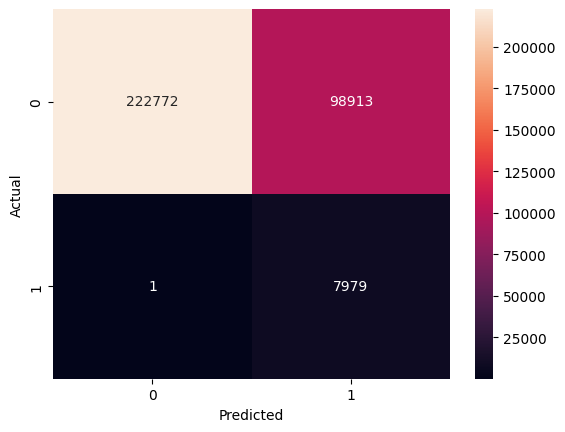

In [411]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

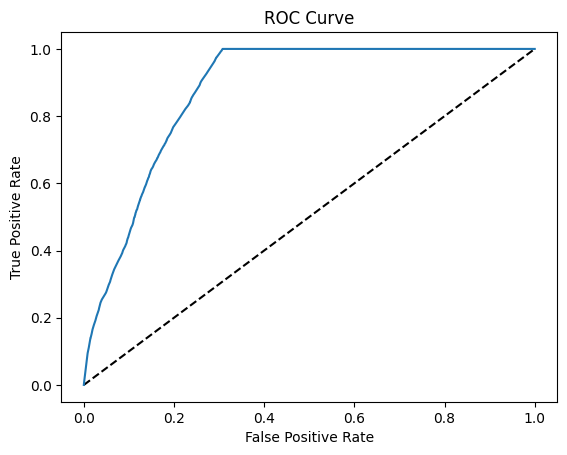

AUC: 0.8773575447392593


In [412]:
# Compute predicted probabilities
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

We can see definite improvements between our models from Uniform Baseline to Decision Tree and Random Forest.


```
# Baseline:
  Accuracy: 50.08205299319005
  Precision: 2.418256958794214
  Recall: 0.4986215538847118
  F1: 0.046127985161140736
```

```
# Decision Tree
Accuracy: 70.92715332231204
Precision: 4.198421551966804
Recall: 0.5046365914786968
F1: 0.07751908139792295
```


```
# Random Forest
Accuracy: 69.99560159555914
Precision: 7.46454365153613
Recall: 0.999874686716792
F1: 0.1389198412145693
ROC-AUC: 0.8773575447392593
```

However, we were able to improve upon them all with our final model.


#Final Model — Logistic Regression

###We define a logistic regression model to predict whether an individual experiences death or a severe injury in a crash. We will optimize the hyperparameters of the model to determine the best solver and inverse of the regularization strength for our model. Our goal is to maximize recall while still maintaining some level of accuracy. We will also look to maximize the AUC score.

In [377]:
#Separate our X and y variables
y=df['Has_Serious_Injury']
X=df[['PERSON_TYPE', 'SEX', 'AGE',
       'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'BAC_RESULT', 'BAC_RESULT_VALUE',
       'is_driver', 'total_drivers_in_crash',
       'CRASH_HOUR', 'POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'ROAD_DEFECT', 'CRASH_TYPE',
       'HIT_AND_RUN_I', 'PRIM_CONTRIBUTORY_CAUSE', 'Under_Influence']]

In [378]:
#Train test split
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=10)

In [379]:
#Impute median BAC value when test was taken and result not recorded. If test was not offered impute 0
bac_median=X_train['BAC_RESULT_VALUE'].median()
X_train.loc[X_train['BAC_RESULT_VALUE'].isna(), 'BAC_RESULT_VALUE']=X_train['BAC_RESULT'].apply(lambda x: 0 if x=='TEST NOT OFFERED' else bac_median)
X_test.loc[X_test['BAC_RESULT_VALUE'].isna(), 'BAC_RESULT_VALUE']=X_test['BAC_RESULT'].apply(lambda x: 0 if x=='TEST NOT OFFERED' else bac_median)

#Clean up columns with redundant different values
X_train['DRIVER_ACTION'].fillna('UNKNOWN', inplace=True)
X_train['DRIVER_ACTION']=X_train['DRIVER_ACTION'].apply(lambda x: 'UNKNOWN' if x=='NONE' else x)

X_test['DRIVER_ACTION'].fillna('UNKNOWN', inplace=True)
X_test['DRIVER_ACTION']=X_test['DRIVER_ACTION'].apply(lambda x: 'UNKNOWN' if x=='NONE' else x)

X_train['DRIVER_VISION']=X_train['DRIVER_VISION'].apply(lambda x: 'NOT OBSCURED' if x in ['UNKNOWN', 'OTHER'] else x)
X_train['DRIVER_VISION'].fillna('NOT OBSCURED', inplace=True)

X_test['DRIVER_VISION']=X_test['DRIVER_VISION'].apply(lambda x: 'NOT OBSCURED' if x in ['UNKNOWN', 'OTHER'] else x)
X_test['DRIVER_VISION'].fillna('NOT OBSCURED', inplace=True)

#Use BAC result to determine whether someone is drunk, impaired, or sober
def alcohol_use(x):
    if x>0 and x<0.08:
        return 'HAD BEEN DRINKING'
    elif x>=0.08:
        return 'IMPAIRED - ALCOHOL'
    elif x==0:
        return 'NORMAL'
X_train.loc[X_train['PHYSICAL_CONDITION'].isna(), 'PHYSICAL_CONDITION']=X_train['BAC_RESULT_VALUE'].apply(alcohol_use)
X_test.loc[X_test['PHYSICAL_CONDITION'].isna(), 'PHYSICAL_CONDITION']=X_test['BAC_RESULT_VALUE'].apply(alcohol_use)

y_train.reset_index(drop=True, inplace=True)

#Impute missing sex values based on distribution of data.
n_males=X_train['SEX'].value_counts()['M']
n_females=X_train['SEX'].value_counts()['F']
def sex_fixer(x):
    r=random.randint(1, n_males+n_females)
    if r<=n_males:
        return 'M'
    else:
        return 'F'

X_train.loc[X_train['SEX'].isna(), 'SEX']=X_train.loc[X_train['SEX'].isna(), 'SEX'].apply(sex_fixer)
X_train.loc[X_train['SEX']=='X', 'SEX']=X_train.loc[X_train['SEX']=='X', 'SEX'].apply(sex_fixer)

X_test.loc[X_test['SEX'].isna(), 'SEX']=X_test.loc[X_test['SEX'].isna(), 'SEX'].apply(sex_fixer)
X_test.loc[X_test['SEX']=='X', 'SEX']=X_test.loc[X_test['SEX']=='X', 'SEX'].apply(sex_fixer)

In [380]:
#Select the numeric and categorical columns we will use, and create encoded dataframe.

ohe=OneHotEncoder(sparse=False, drop='first')

X_train_categoricals=X_train[['PERSON_TYPE', 'DRIVER_ACTION', 'LIGHTING_CONDITION', 'CRASH_TYPE', 'SEX']]
X_test_categoricals=X_test[['PERSON_TYPE', 'DRIVER_ACTION', 'LIGHTING_CONDITION', 'CRASH_TYPE', 'SEX']]

X_train_categoricals_encoded=pd.DataFrame(ohe.fit_transform(X_train_categoricals))
X_test_categoricals_encoded=pd.DataFrame(ohe.transform(X_test_categoricals))
X_train_categoricals_encoded=X_train_categoricals_encoded.apply(np.float32)
X_test_categoricals_encoded=X_test_categoricals_encoded.apply(np.float32)

X_train_numeric=X_train[['is_driver', 'total_drivers_in_crash', 'POSTED_SPEED_LIMIT', 'Under_Influence']]
X_train_numeric.reset_index(drop=True, inplace=True)
X_train_numeric=X_train_numeric.apply(np.float32)

X_test_numeric=X_test[['is_driver', 'total_drivers_in_crash', 'POSTED_SPEED_LIMIT', 'Under_Influence']]
X_test_numeric.reset_index(drop=True, inplace=True)
X_test_numeric=X_test_numeric.apply(np.float32)

X_train_encoded=pd.merge(X_train_numeric, X_train_categoricals_encoded, left_index=True, right_index=True)
X_test_encoded=pd.merge(X_test_numeric, X_test_categoricals_encoded, left_index=True, right_index=True)

In [381]:
# Convert all column names to string type to be compatible with latest SMOTE version
X_train_encoded.columns = X_train_encoded.columns.astype(str)
X_test_encoded.columns = X_test_encoded.columns.astype(str)

#Oversample minority class (0, which represents no injury or death) to balance data.
sm=SMOTE(random_state=10)
X_train_resampled, y_train_resampled=sm.fit_resample(X_train_encoded,y_train)

#Fit the first model
logreg=LogisticRegression(random_state=10)
logreg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=10)

In [382]:
#Display metrics
y_preds=logreg.predict(X_test_encoded)
print(f'Accuracy: {accuracy_score(y_test, y_preds)}')
print(f'Precision: {precision_score(y_test, y_preds)}')
print(f'Recall: {recall_score(y_test, y_preds)}')
print(f'F1: {f1_score(y_test, y_preds)}')

y_score=logreg.decision_function(X_test_encoded)
roc_auc_score(y_test, y_score)

Accuracy: 0.6999681494850833
Precision: 0.07464822992290997
Recall: 0.999874686716792
F1: 0.13892467876170914


0.8728243423190303

##Hypertuning parameters first with `RandomizedSearchCV` then with `GridSearchCV`

### Hypertuning with `RandomizedSearchCV`

In [ ]:
# Specify hyperparameters and their distributions
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
parameters = {'C': C, 'solver': solver}

# Instantiate RandomizedSearchCV object
random_search = RandomizedSearchCV(logreg, parameters, n_iter=10, cv=5, random_state=10)

# Fit on data
random_search.fit(X_train_resampled[:10000], y_train_resampled[:10000])

# Get the best parameters
best_c, best_solver = random_search.best_params_['C'], random_search.best_params_['solver']

Accuracy score: 0.6999833163969484
Precision score: 0.07465172197636669
Recall score: 0.999874686716792
F1 score score: 0.13893072616943664
ROC-AUC score: 0.8726466242544981


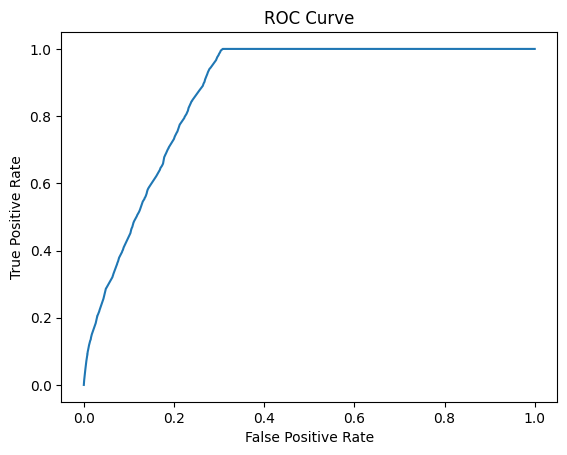

In [ ]:
#Updating the logistic regression model to have the optimized parameters:
logreg_2=LogisticRegression(C=best_c, solver=best_solver, random_state=10)
logreg_2.fit(X_train_resampled, y_train_resampled)

#Display metrics
y_preds=logreg_2.predict(X_test_encoded)
print(f'Accuracy score: {accuracy_score(y_test, y_preds)}')
print(f'Precision score: {precision_score(y_test, y_preds)}')
print(f'Recall score: {recall_score(y_test, y_preds)}')
print(f'F1 score score: {f1_score(y_test, y_preds)}')

y_score=logreg_2.decision_function(X_test_encoded)
print(f'ROC-AUC score: {roc_auc_score(y_test, y_score)}')

#Display ROC Curve
y_predicted=logreg_2.predict_proba(X_test_encoded)[::,1]
fpr, tpr, results=roc_curve(y_test, y_predicted)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve');

In [ ]:
#Create dictionary showing model coefficients
coefficients={}
for n in range (len(X_train_numeric.columns)):
    coefficients[X_train_numeric.columns[n]]=np.exp(logreg_2.coef_[0][n])
features=X_train_categoricals.columns
start=len(X_train_numeric.columns)
stop=len(X_train_numeric.columns)
for f in features:
    stop+=len(X_train[f].value_counts())-1
    coefficients[f]=np.exp(logreg_2.coef_[0][start:stop])
    start=stop

coefficients

{'is_driver': 0.6474223,
 'total_drivers_in_crash': 1.0234797,
 'POSTED_SPEED_LIMIT': 1.0139914,
 'Under_Influence': 1.1544747,
 'PERSON_TYPE': array([0.6474223 , 0.60653067, 0.58134943, 0.5865978 , 1.896065  ],
       dtype=float32),
 'DRIVER_ACTION': array([0.4627561 , 1.0491129 , 0.93652016, 0.9394131 , 0.94317263,
        0.50801474, 1.0644945 , 0.9997541 , 0.87347966], dtype=float32),
 'LIGHTING_CONDITION': array([1.1218671 , 1.1349783 , 0.9813235 , 0.94069844, 0.6133221 ],
       dtype=float32),
 'CRASH_TYPE': array([5.4901915e-07], dtype=float32),
 'SEX': array([1.0922178], dtype=float32)}

In [ ]:
driver_reduction=round(1-coefficients['is_driver'], 2)*100
dui_increase=round(coefficients['Under_Influence']-1, 2)*100
sex_increase=round(coefficients['SEX'][0]-1, 2)*100

print(f'Drivers experience a {driver_reduction}% reduction in their odds of death/severe injury compared to passengers and cyclists.')
print(f'A driver being under the influence raises the odds of a death/severe injury occurring by {dui_increase}%.')
print(f'Men have {sex_increase}% higher odds of death/severe injury than women.')

Drivers experience a 35.0% reduction in their odds of death/severe injury compared to passengers and cyclists.
A driver being under the influence raises the odds of a death/severe injury occurring by 15.0%.
Men have 9.0% higher odds of death/severe injury than women.


### Hypertuning with `GridSearchCV`

In [392]:
#Optimize hyperparameters using grid search
C=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver=['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
parameters={'C': C, 'solver': solver}

clf=GridSearchCV(logreg, parameters)
clf.fit(X_train_resampled[:10000], y_train_resampled[:10000])
best_c, best_solver=clf.best_params_['C'], clf.best_params_['solver']

Accuracy score: 0.6999681494850833
Precision score: 0.07464822992290997
Recall score: 0.999874686716792
F1 score score: 0.13892467876170914
ROC-AUC score: 0.8725565993881761


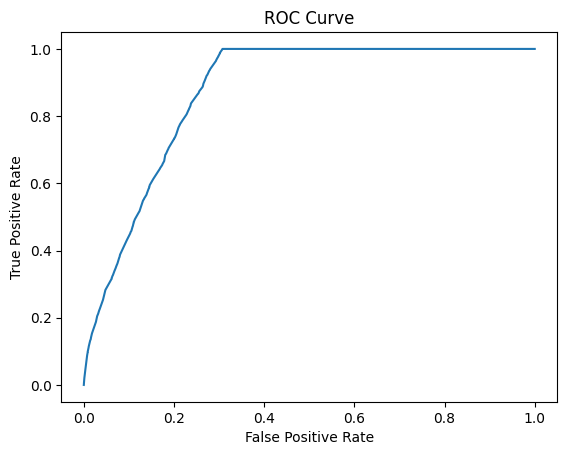

In [393]:
#Updating the logistic regression model to have the optimized parameters:
logreg_2=LogisticRegression(C=best_c, solver=best_solver, random_state=10)
logreg_2.fit(X_train_resampled, y_train_resampled)

#Display metrics
y_preds=logreg_2.predict(X_test_encoded)
print(f'Accuracy score: {accuracy_score(y_test, y_preds)}')
print(f'Precision score: {precision_score(y_test, y_preds)}')
print(f'Recall score: {recall_score(y_test, y_preds)}')
print(f'F1 score score: {f1_score(y_test, y_preds)}')

y_score=logreg_2.decision_function(X_test_encoded)
print(f'ROC-AUC score: {roc_auc_score(y_test, y_score)}')

#Display ROC Curve
y_predicted=logreg_2.predict_proba(X_test_encoded)[::,1]
fpr, tpr, results=roc_curve(y_test, y_predicted)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve');

In [394]:
#Create dictionary showing model coefficients
coefficients={}
for n in range (len(X_train_numeric.columns)):
    coefficients[X_train_numeric.columns[n]]=np.exp(logreg_2.coef_[0][n])
features=X_train_categoricals.columns
start=len(X_train_numeric.columns)
stop=len(X_train_numeric.columns)
for f in features:
    stop+=len(X_train[f].value_counts())-1
    coefficients[f]=np.exp(logreg_2.coef_[0][start:stop])
    start=stop

coefficients

{'is_driver': 0.7105502554153093,
 'total_drivers_in_crash': 1.0269714487408612,
 'POSTED_SPEED_LIMIT': 1.0163639303003176,
 'Under_Influence': 1.130943572371686,
 'PERSON_TYPE': array([0.71055026, 0.9785312 , 0.95748925, 0.71246387, 2.25941833]),
 'DRIVER_ACTION': array([0.90321052, 1.01328146, 1.00354562, 0.99792731, 0.95657716,
        0.9022896 , 1.08303705, 1.00034865, 0.88738133]),
 'LIGHTING_CONDITION': array([1.18798979, 1.21273794, 1.04714866, 1.01903542, 0.74953068]),
 'CRASH_TYPE': array([0.00353479]),
 'SEX': array([1.09679281])}

## Findings from final model:

In [ ]:
driver_reduction=round(1-coefficients['is_driver'], 2)*100
dui_increase=round(coefficients['Under_Influence']-1, 2)*100
sex_increase=round(coefficients['SEX'][0]-1, 2)*100

print(f'Drivers experience a {driver_reduction}% reduction in their odds of death/severe injury compared to passengers and cyclists.')
print(f'A driver being under the influence raises the odds of a death/severe injury occurring by {dui_increase}%.')
print(f'Men have {sex_increase}% higher odds of death/severe injury than women.')

Drivers experience a 28.999999999999996% reduction in their odds of death/severe injury compared to passengers and cyclists.
A driver being under the influence raises the odds of a death/severe injury occurring by 13.0%.
Men have 10.0% higher odds of death/severe injury than women.


#Conclusion

We made significant improvements in our key metric (recall) between the baseline, decision tree, and random forest models. Improvements were slight when iterating on the logistic regression model and did not dramatically alter the main conclusions we can draw from them.

Our random forest model and logistic regression models were able to almost completely eliminate false negatives. In the context of our business problem and stakeholder, this is the preferable outcome to support their mission to pervent loss of life or severe injury in the event of a car crash.

##Model Iteration/Evaluation Recap
The slight difference in outcomes in our final model (logistic regression) between hypertuning the parameters using random search and grid search suggest a relative stability in coefficients.

The odds of death/severe injury for drivers compared to passengers and cyclists decrease by 35% after hypertuning with random search and by 29% after hypertuning with grid search.

The odds of death/severe injury when the driver is under the influence increase by 15% after hypertuning with random search and by 13% after hypertuning with grid search.

The odds of death/severe injury for men compared to women increase by 10% after hypertuning with random search and by 9% after hypertuning with grid search.

###Model Scoring
```
# Baseline:
  Accuracy: 50.08205299319005
  Precision: 2.418256958794214
  Recall: 0.4986215538847118
  F1: 0.046127985161140736
```

```
# Decision Tree
Accuracy: 70.92715332231204
Precision: 4.198421551966804
Recall: 0.5046365914786968
F1: 0.07751908139792295
```

Random Forest: This model seems to perform the best in terms of the ROC-AUC score, which is a comprehensive metric that considers both the true positive rate and the false positive rate. It's a preferred metric when the classes are imbalanced.
```
# Random Forest
Accuracy: 69.99560159555914
Precision: 7.46454365153613
Recall: 0.999874686716792
F1: 0.1389198412145693
ROC-AUC: 0.8773575447392593
```
Logistic Regression (before hypertuning): The performance of this model is almost identical to the two hypertuned versions, which suggests that the hyperparameter tuning did not significantly improve the performance in this case.
```
# Logistic Regression (before hypertuning)
Accuracy: 69.99681494850833
Precision: 7.464822992290997
Recall: 0.999874686716792
F1: 0.13892467876170914
ROC-AUC: 0.8728243423190303
```
Logistic Regression (hypertuning with random search): This version of Logistic Regression achieves the highest accuracy and precision scores. However, these metrics can sometimes be misleading if the classes are heavily imbalanced. We accounted for this by using SMOTE to oversample the minority class.

```
# Logistic Regression (hypertuning with random search)
Accuracy: 69.99833163969484
Precision: 7.465172197636669
Recall: 0.999874686716792
F1: 0.13893072616943664
ROC-AUC: 0.8726466242544981

```
Logistic Regression (hypertuning with grid search): This model has almost identical performance to the Logistic Regression model with random search. The differences in the evaluation metrics are very small and may not be significant.
```
# Logistic Regression (hypertuning with grid search)
Accuracy: 69.99681494850833
Precision: 7.464822992290997
Recall: 0.999874686716792
F1: 0.13892467876170914
ROC-AUC: 0.8725565993881761
```

